In [2]:
#引包

import pandas as pd 
import numpy as np
from scipy.signal import medfilt
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch
from torch.nn import init
import torch.nn.functional as F
import time

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [3]:
#初始参数
window_size = 1250
no_of_task = np.array(['原信号', '噪音', '取负', '时间反向', '打乱片段'] )
no_of_emo = np.array(['平静', '积极', '惊恐', '恶心'] )

no_of_valence = np.array(['消极','积极'])
no_of_arousal = np.array(['强度低','强度高'])

transform_task = [0, 1, 2, 3, 4]
single_batch_size = len(transform_task)


noise_param = 15 #noise_amount
scale_param = 1.1 #scaling_factor
permu_param = 20 #permutation_pieces

## hyper parameters
total_fold = 10
dropout_rate = 0.5
batchsize = 512
actual_batch_size =  batchsize * single_batch_size
lr_decay_step = 50
lr_decay_rate = 0.6
epoch = 250
t_epoch = 70
initial_learning_rate = 0.0001
loss_coeff = [0.229, 0.227, 0.227, 0.045, 0.045, 0.227]

In [39]:
#网络结构 
class model_CNN(nn.Module):
    def __init__(self):
        super(model_CNN,self).__init__()
        self.conv_unit = nn.Sequential(
            nn.BatchNorm1d(1),
            
            nn.Conv1d(in_channels=1,out_channels=32,kernel_size=33,stride=1,padding=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            
            nn.MaxPool1d(8,stride=2),#（1250-8+2*0）/2 + 1 = 622
            
            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=17,stride=1,padding=8),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),#622*64
            nn.Dropout(0.2),
            
            nn.MaxPool1d(8,stride=2),#（622-8+2*0）/2 + 1 = 308
            
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=9,stride=1,padding=4),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.MaxPool1d(308),#308*128
            
            nn.Flatten(),#1*128
            nn.Dropout(0.2),#没有dropout，准确率会先上升后下降，最后涨到1？过拟合
        )
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练
        inputs = inputs.view(inputs.size()[0],1,inputs.size()[1])
        #inputs = inputs.view(1,1,inputs.size()[0])#only a batch
        inputs = self.conv_unit(inputs)
        inputs = inputs.view(inputs.size()[0],-1)
        #inputs = self.dense_unit(inputs)

        return inputs

class model_Task(nn.Module):
    def __init__(self):
        super(model_Task,self).__init__()

        self.task0 = nn.Sequential(
            nn.Linear(128,128),#1*128
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,5),
            #nn.Softmax(dim=1)
        )
        
        
    def forward(self,inputs):

        out0 = self.task0(inputs)

        return out0
    
    
class model_valence(nn.Module):
    def __init__(self):
        super(model_valence,self).__init__()

        self.task_v = nn.Sequential(
            nn.Linear(128,256),#1*128
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(128,2),
            #nn.Softmax(dim=1)#pytorch crossentropyloss 不需要
        )
        
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练

        inputs = self.task_v(inputs)

        return inputs
    
class model_arousal(nn.Module):
    def __init__(self):
        super(model_arousal,self).__init__()

        self.task_a = nn.Sequential(
            nn.Linear(128,256),#1*128
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,2),
            #nn.Softmax(dim=1)#pytorch crossentropyloss 不需要
        )
        
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练

        inputs = self.task_a(inputs)

        return inputs
    
#define the initial function to init the layer's parameters for the network
def weigth_init(m):
    if isinstance(m, nn.Conv1d):
        init.xavier_uniform_(m.weight.data)
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0,0.01)
        m.bias.data.zero_()


In [5]:
# 解决中文显示问题 绘制
# import os
# import pandas as pd
# import numpy as np
# import torch
# from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 定义画图函数
def plot_loss(epochs, train_loss, val_loss, text):
    x = np.arange(1,epochs+1)
    
    plt.plot(x,train_loss, label='train_loss')
    plt.plot(x,val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(text+"loss 图")
    plt.savefig('/home/whh/lt/pic/loss.png')
    plt.show()


def plot_acc(epochs, train_acc, val_acc, text):
    x = np.arange(1,epochs+1)
    
    plt.plot(x,train_acc, label='train_acc')
    plt.plot(x,val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.title(text+"acc 图")
    plt.savefig('/home/whh/lt/pic/acc.png')
    plt.show()


def plot_results(epochs, train_acc, train_loss, val_acc, val_loss, text):
    x = np.arange(1,epochs+1)

    plt.plot(x, train_acc, label='train_accuracy')
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, val_acc, label='val_accuracy')
    plt.plot(x, val_loss, label='val_loss')

    plt.title(text+"loss&acc ", fontsize=15)
    plt.xlabel("X", fontsize=13)
    plt.ylabel("Y", fontsize=13)
    plt.legend()
    plt.savefig('/home/whh/lt/pic/result.png')
    plt.show()

def plot_all(epochs, train_acc, train_loss, val_acc, val_loss, text):
    
    plot_acc(epochs, train_acc, val_acc, text)
    plot_loss(epochs, train_loss, val_loss, text)
    plot_results(epochs, train_acc, train_loss, val_acc, val_loss, text)
    
def get_confusion_matrix(trues, preds):
  conf_matrix = confusion_matrix(y_true = no_of_task[trues],y_pred = no_of_task[preds], labels = no_of_task )
  return conf_matrix
  
def plot_confusion_matrix(conf_matrix):
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)
  indices = range(conf_matrix.shape[0])
  plt.xticks(indices, no_of_task )
  plt.yticks(indices, no_of_task )
  plt.colorbar()
  plt.xlabel('预测')
  plt.ylabel('真实')
  # 显示数据
  for first_index in range(conf_matrix.shape[1]):
    for second_index in range(conf_matrix.shape[0]):
      plt.text(first_index, second_index, conf_matrix[second_index, first_index])
  plt.savefig('/home/whh/lt/pic/pretask_heatmap_confusion_matrix.jpg')
  plt.show()

    
def get_confusion_matrix2(trues, preds, no_of_emo):
  conf_matrix = confusion_matrix(y_true = no_of_emo[trues],y_pred = no_of_emo[preds], labels = no_of_emo )
  return conf_matrix
  
def plot_confusion_matrix2(conf_matrix, no_of_emo):
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)
  indices = range(conf_matrix.shape[0])
  plt.xticks(indices, no_of_emo )
  plt.yticks(indices, no_of_emo )
  plt.colorbar()
  plt.xlabel('预测')
  plt.ylabel('真实')
  # 显示数据
  for first_index in range(conf_matrix.shape[1]):
    for second_index in range(conf_matrix.shape[0]):
      plt.text(first_index, second_index, conf_matrix[second_index, first_index])
  plt.savefig('/home/whh/lt/pic/downstream_heatmap_confusion_matrix.jpg')
  plt.show()
    

In [6]:
#数据处理
def medfilt_ecg(original_ecg, window_size):
    # 确保窗大小变为奇数 
    window_size = window_size+1 if window_size % 2 == 0 else window_size
    give_up_size = int(window_size / 2)
    ecg_baseline = medfilt(original_ecg, window_size)
    totality_bias = np.sum(ecg_baseline[give_up_size:-give_up_size])/(len(original_ecg)-2*give_up_size)
    filtered_ecg = original_ecg - ecg_baseline
    final_filtered_ecg = filtered_ecg[give_up_size:-give_up_size]-totality_bias
    return final_filtered_ecg

def minus_ecg(original_ecg):
    ecg = (-1) * original_ecg
    return ecg

def shuffle_ecg(original_ecg,pieces):
    signal = original_ecg
    ecg =[]
    
    pieces       = int(np.ceil(np.shape(signal)[0]/(np.shape(signal)[0]//pieces)).tolist())
    piece_length = int(np.shape(signal)[0]//pieces)
    
    sequence = list(range(0,pieces))
    np.random.shuffle(sequence)
    
    permuted_signal = np.reshape(signal[:(np.shape(signal)[0]//pieces*pieces)], (pieces, piece_length)).tolist() + [signal[(np.shape(signal)[0]//pieces*pieces):]]
    
    for i in range(pieces):
        ecg += permuted_signal[sequence[i]]
    ecg.extend(permuted_signal[21])
    ecg = np.array(ecg,dtype = np.float32)
#     permuted_signal = np.asarray(permuted_signal,dtype=np.float32)[sequence]
#     ecg = np.hstack(permuted_signal))
    
    return ecg

def flip_ecg(original_ecg):
    
    ecg = np.flip(original_ecg)
    return ecg

def add_noise_with_SNR(original_ecg, noise_amount):
    signal = original_ecg
    
    target_snr_db = noise_amount #20
    x_watts = signal ** 2                       # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)   # Calculate noise then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))     # Generate an sample of white noise
    noised_signal = signal + noise_volts        # noise added signal

    return noised_signal 

In [7]:
#数据划分
def get_train_test_index(data, kf, bias):
    train_index = []
    test_index = []
    for train_i, test_i in kf.split(data):
        train_index.append(train_i + bias)
        test_index.append(test_i + bias)

    return train_index, test_index

def make_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces):
    """
    genrator to do signal transformation and then make a batch of 7, which is a batch contains all transformed signal with original signal"""
    
    for i in range(len(signal_batch)):
        
        signal              = signal_batch[i]
        #signal              = np.trim_zeros(signal, 'b')
        sampling_freq       = len(signal)//10
        noised_signal       = add_noise_with_SNR(signal, noise_amount = noise_amount) #round(np.random.uniform(0.005,0.05),2)) # 0.005 - 0.05
        negated_signal      = minus_ecg(signal)
        flipped_signal      = flip_ecg(signal)
        permuted_signal     = shuffle_ecg(signal, pieces = permutation_pieces) # 2-20
        
        signal                  = signal.reshape(1,len(signal))
        noised_signal           = noised_signal.reshape(1,len(noised_signal))
        negated_signal          = negated_signal.reshape(1,len(negated_signal))
        flipped_signal          = flipped_signal.reshape(1,len(flipped_signal))
        permuted_signal         = permuted_signal.reshape(1,len(permuted_signal))

        batch = np.vstack((signal.astype(np.float32), noised_signal.astype(np.float32)))
        batch = np.vstack((batch, negated_signal.astype(np.float32)))
        batch = np.vstack((batch, flipped_signal.astype(np.float32)))
        batch = np.vstack((batch, permuted_signal.astype(np.float32)))#2560*7
        
        labels = transform_task#shuffle
        np.random.shuffle(labels)
        batch = batch[labels]
        
        labels = np.array(labels).reshape(len(transform_task),1)
        
#         data_tensor = torch.LongTensor(labels)
#         labels = F.one_hot(data_tensor) 
    
        yield np.array(batch,dtype=np.float32), labels#128*6*1250
        
def make_total_batch(data, length, batchsize, noise_amount, scaling_factor, permutation_pieces):
    """ calling make_batch from here, when batch size is more than one, like 64 or 32, it will make actual batch size = batch_size * len(transformed signal)
    """
    steps = length // batchsize +1
    for counter in range(steps):

        signal_batch = data[np.mod(np.arange(counter*batchsize,(counter+1)*batchsize), length)]
        
        gen_op =  make_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces)
        total_batch = np.array([])
        total_labels = np.array([])
        for batch, labels in gen_op:

            total_batch = np.vstack((total_batch, batch)) if len(total_batch) else batch # 2560 * 7个， 且最后一个batch不够128的话从前面取值补上去
            total_labels = np.vstack((total_labels, labels)) if len(total_labels) else labels

        yield np.array(total_batch,dtype=np.float32), total_labels, counter, steps#total batch中有128个数据，一个数据有7*2560个，即原信号+处理的信号共7个
        


In [8]:
# 加载原始数据
class MyData(Data.Dataset):
    def __init__(self, feature, label):
        self.feature = feature # 特征
        self.label = label # 标签

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]
    
    

def make_10(signals,label,train_signals_final,train_labels_final):
    train_signals = []
    
    mid_num = len(signals[0:(len(signals)-1250)])//125
    for i in range(mid_num):
        train_signals = np.vstack((train_signals,signals[i*125:i*125+1250]))if len(train_signals)!=0 else signals[i*125:i*125+1250]
    
#     mid_num = len(train_signals)//1250
#     train_signals= np.array_split(train_signals[:int(mid_num*1250)],mid_num)
    
    train_signals_final = np.vstack((train_signals_final,train_signals))if len(train_signals_final)!=0 else train_signals
    train_labels = np.full(int(mid_num),label) 
    train_labels_final = np.append(train_labels_final,train_labels)if len(train_labels_final)!=0 else train_labels
    return train_signals_final,train_labels_final

def load_data_positive():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    #yangnan
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681356983934.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357438489.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357726357.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358093581.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)

        #wuhongfu
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681289705242.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290117226.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290298306.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290764665.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        #tancheng
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681361364631.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362030617.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362348275.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362617464.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)

       #sunmingrui
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297303103.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297646913.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298381797.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298714707.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        #mobiao
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681306855404.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307342620.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307738678.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307968220.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    

       # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681196859_pro_2_1681196592744.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197134_pro_2_1681196863225.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive3
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197718_pro_2_1681197431761.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197849_pro_2_1681197769541.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    



    
    return train_signals_final,train_labels_final

def load_data_negative():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    # 加载原始数据negative1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358278670.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    fear = train_signals
    train_signals_final,train_labels_final = make_10(fear,0,train_signals_final,train_labels_final)
    
    # 加载原始数据negative2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358569551.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290914931.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681363292190.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681299073795.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681308107324.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    
    fear = train_signals[:45000]
    train_signals_final,train_labels_final = make_10(fear,0,train_signals_final,train_labels_final)
    
    sick = train_signals[45000:]
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_0():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
        # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
 
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197849_pro_2_1681197769541.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    
    sick = train_signals[45000:]
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)

        # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307342620.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
   
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681308107324.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297646913.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681299073795.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362030617.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290117226.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290764665.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290914931.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357438489.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358093581.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
        # 加载原始数据negative2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358569551.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,0,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307968220.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298714707.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362617464.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681363292190.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,1,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final


def load_data_1():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681306855404.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681361364631.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    
        # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290298306.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681196859_pro_2_1681196592744.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197134_pro_2_1681196863225.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
  
        # 加载原始数据positive3
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197718_pro_2_1681197431761.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
 
        # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    
    fear = train_signals[:45000]
    train_signals_final,train_labels_final = make_10(fear,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307738678.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297303103.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298381797.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362348275.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681289705242.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681356983934.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357726357.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
        # 加载原始数据negative1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358278670.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    fear = train_signals
    train_signals_final,train_labels_final = make_10(fear,1,train_signals_final,train_labels_final)
    
    
    return train_signals_final,train_labels_final

In [9]:
#数据加载
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=total_fold, shuffle=True, random_state=True)

train_signals_final,train_labels_final = load_data_positive()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
positive_data = np.hstack((train_labels_final,train_signals_final))
train_index_positive, test_index_positive = get_train_test_index(positive_data, kf, 0)
load_data_v = positive_data

train_signals_final,train_labels_final = load_data_negative()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
negative_data = np.hstack((train_labels_final,train_signals_final))
train_index_negative, test_index_negative = get_train_test_index(negative_data, kf, load_data_v.shape[0])
load_data_v = np.vstack((load_data_v,negative_data))

train_signals_final,train_labels_final = load_data_0()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
a0_data = np.hstack((train_labels_final,train_signals_final))
train_index_0, test_index_0 = get_train_test_index(a0_data, kf, 0)
load_data_a = a0_data

train_signals_final,train_labels_final = load_data_1()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
a1_data = np.hstack((train_labels_final,train_signals_final))
train_index_1, test_index_1 = get_train_test_index(a1_data, kf, load_data_a.shape[0])
load_data_a = np.vstack((load_data_a,a1_data))

In [10]:
print(load_data_v.shape)
print(load_data_a.shape)

(24230, 1251)
(24230, 1251)


=====开始训练网络=====
=====FOLD_0=====
=====情绪识别任务训练开始=====
=====valence=====


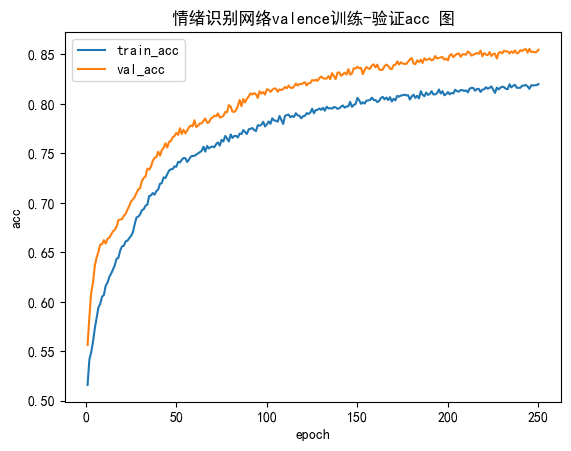

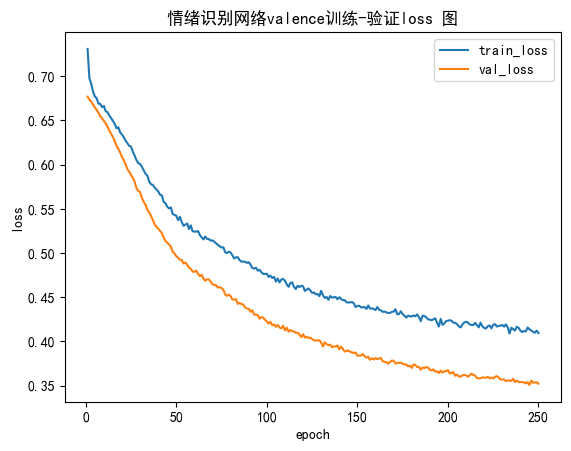

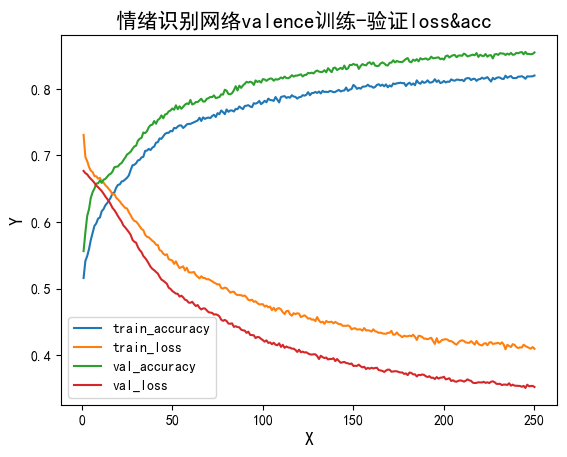

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1320
           1       0.87      0.80      0.83      1104

    accuracy                           0.85      2424
   macro avg       0.86      0.85      0.85      2424
weighted avg       0.86      0.85      0.85      2424

[[1192  128]
 [ 226  878]]


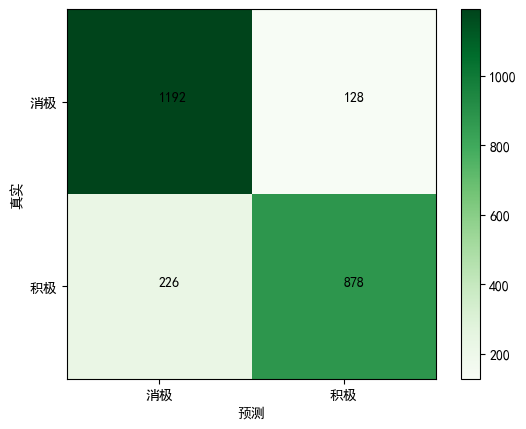

[valence测试] accuracy:0.8540 precision:0.8540 recall:0.8540 f1:0.8540
保存最优情绪识别valence模型model 0
=====arousal=====


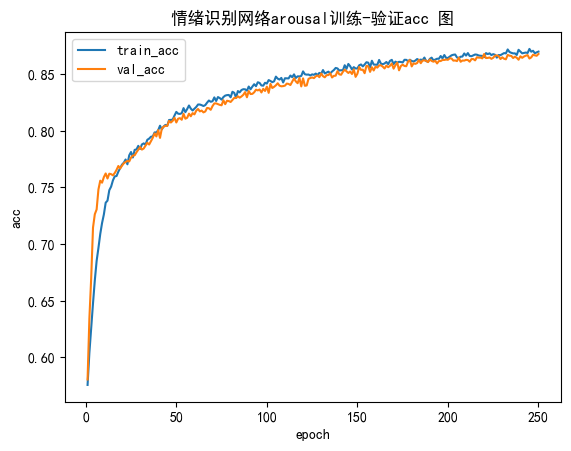

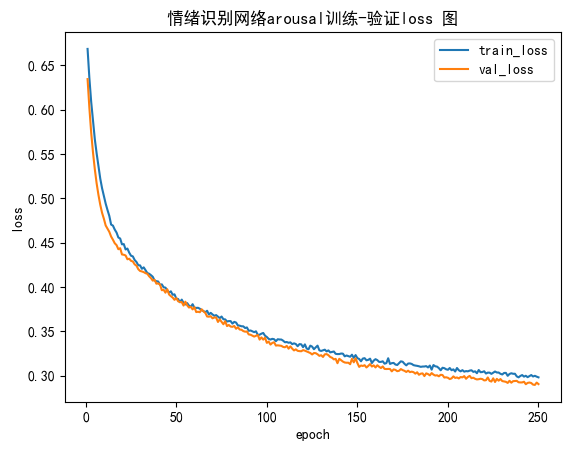

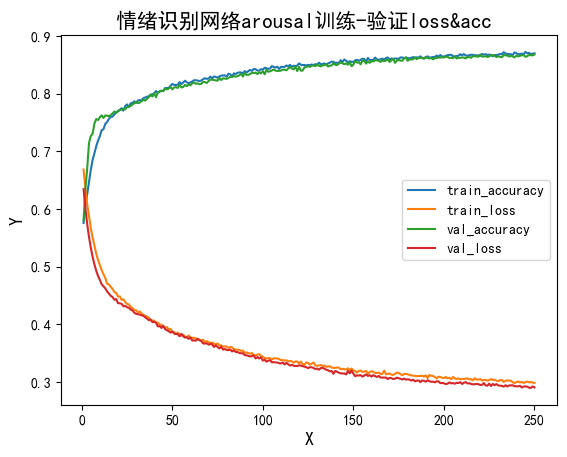

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1015
           1       0.89      0.89      0.89      1409

    accuracy                           0.87      2424
   macro avg       0.86      0.86      0.86      2424
weighted avg       0.87      0.87      0.87      2424

[[ 855  160]
 [ 160 1249]]


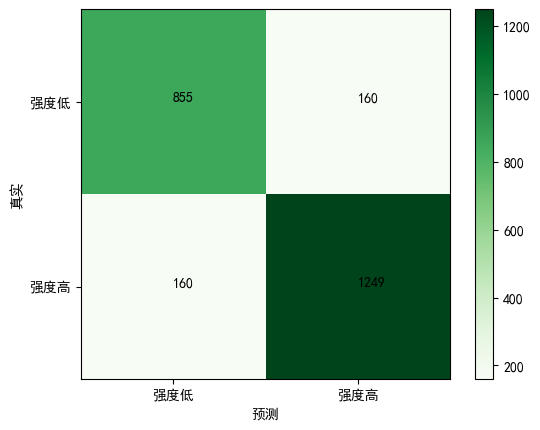

[arousal测试] accuracy:0.8680 precision:0.8680 recall:0.8680 f1:0.8680
保存最优arousal模型model 0
=====FOLD_1=====
=====情绪识别任务训练开始=====
=====valence=====


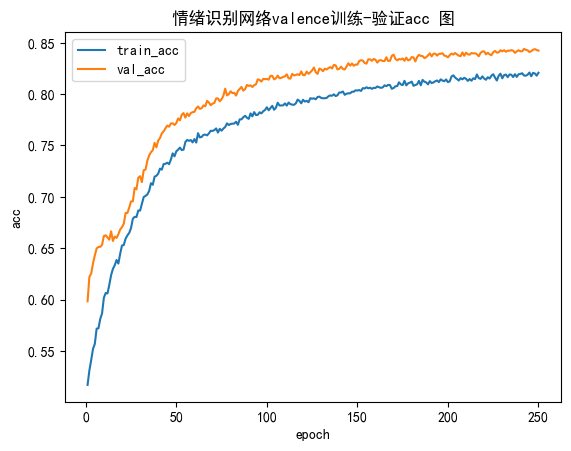

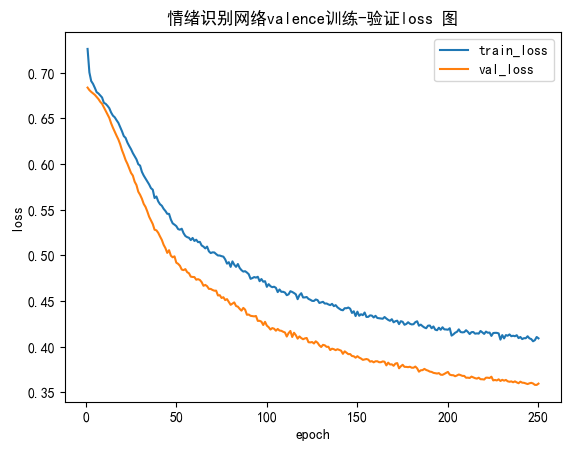

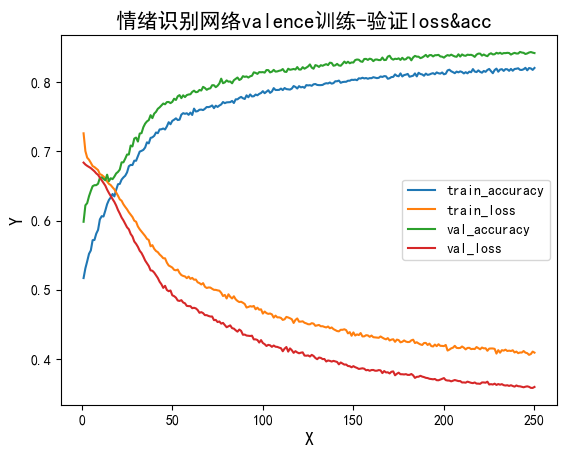

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1320
           1       0.85      0.79      0.82      1104

    accuracy                           0.84      2424
   macro avg       0.84      0.84      0.84      2424
weighted avg       0.84      0.84      0.84      2424

[[1168  152]
 [ 231  873]]


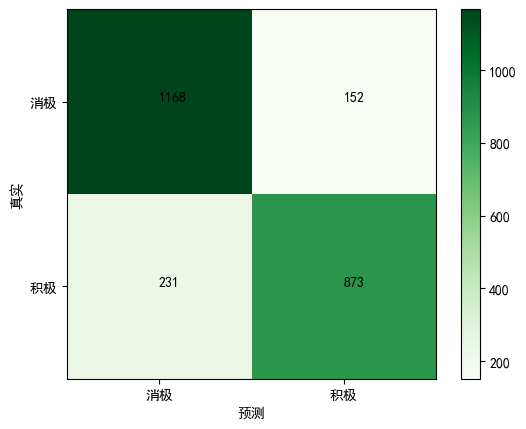

[valence测试] accuracy:0.8420 precision:0.8420 recall:0.8420 f1:0.8420
=====arousal=====


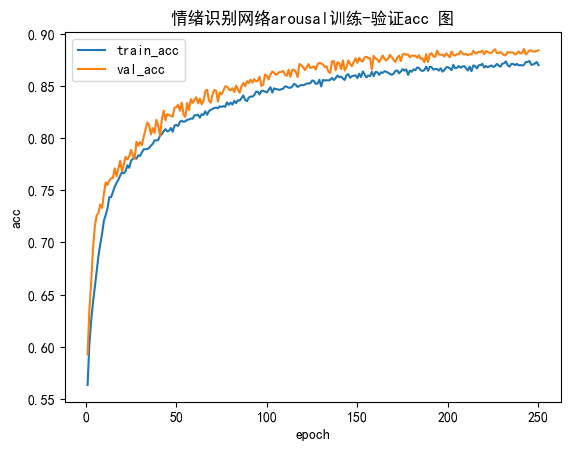

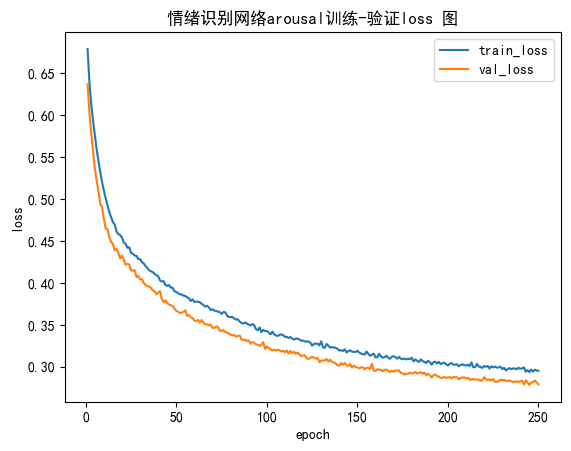

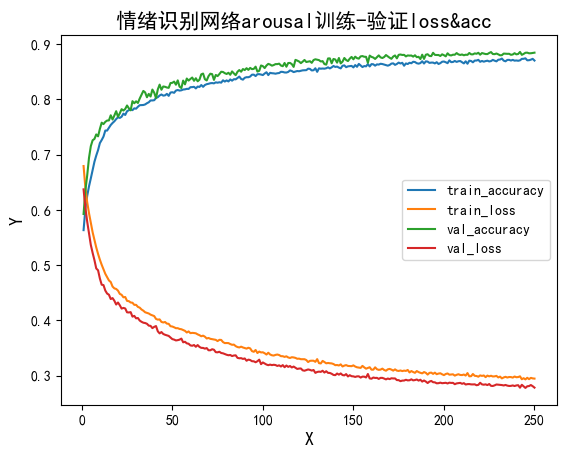

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       985
           1       0.91      0.89      0.90      1438

    accuracy                           0.88      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.88      0.88      0.88      2423

[[ 860  125]
 [ 158 1280]]


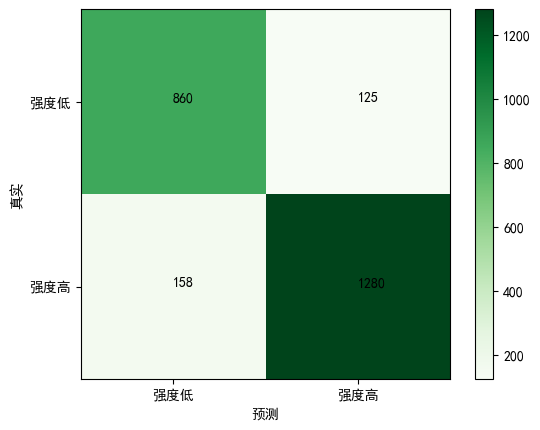

[arousal测试] accuracy:0.8832 precision:0.8832 recall:0.8832 f1:0.8832
保存最优arousal模型model 1
=====FOLD_2=====
=====情绪识别任务训练开始=====
=====valence=====


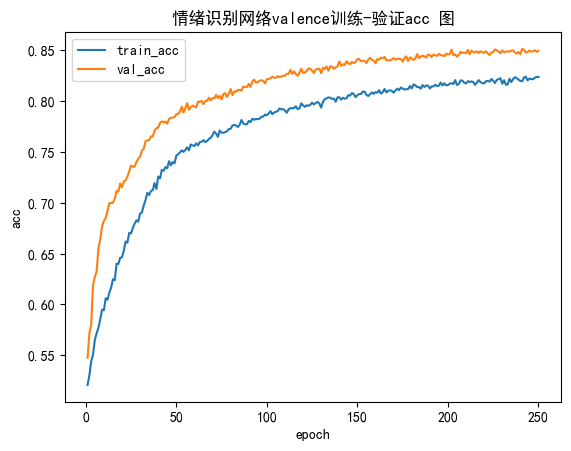

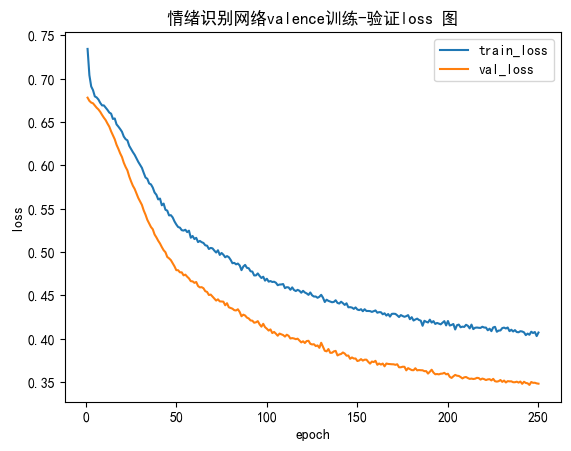

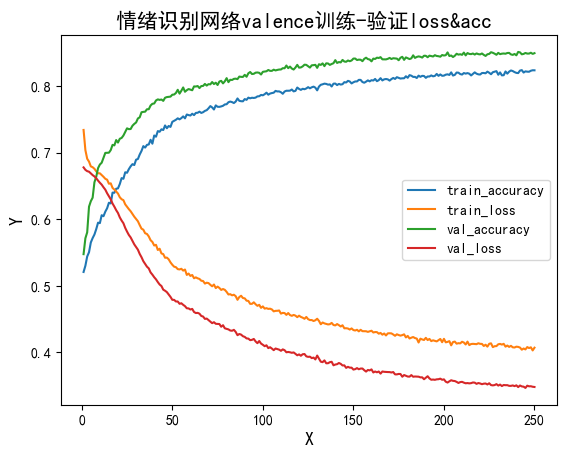

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1320
           1       0.84      0.82      0.83      1104

    accuracy                           0.85      2424
   macro avg       0.85      0.85      0.85      2424
weighted avg       0.85      0.85      0.85      2424

[[1152  168]
 [ 197  907]]


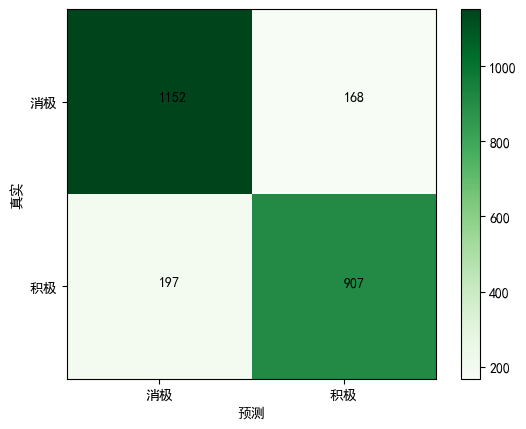

[valence测试] accuracy:0.8494 precision:0.8494 recall:0.8494 f1:0.8494
=====arousal=====


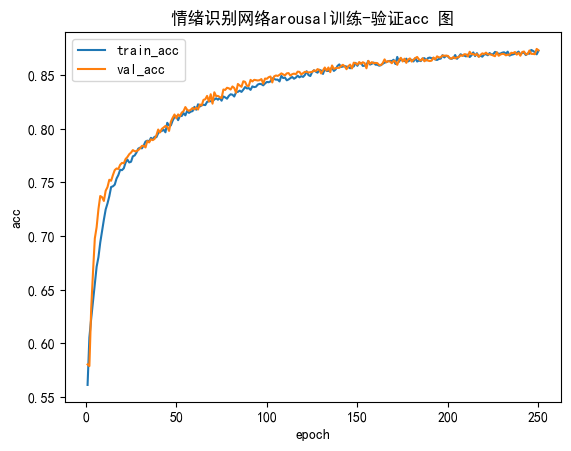

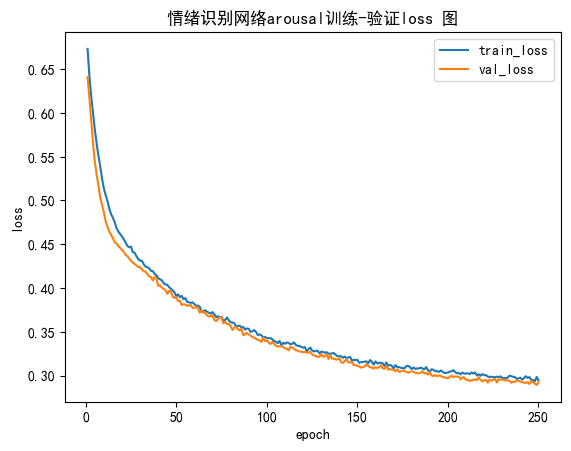

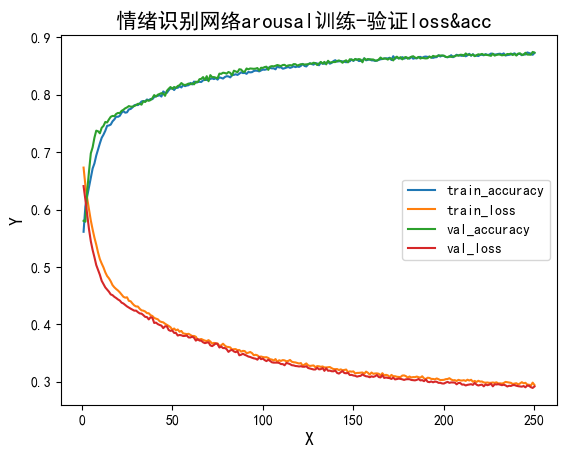

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1021
           1       0.89      0.89      0.89      1402

    accuracy                           0.87      2423
   macro avg       0.87      0.87      0.87      2423
weighted avg       0.87      0.87      0.87      2423

[[ 870  151]
 [ 156 1246]]


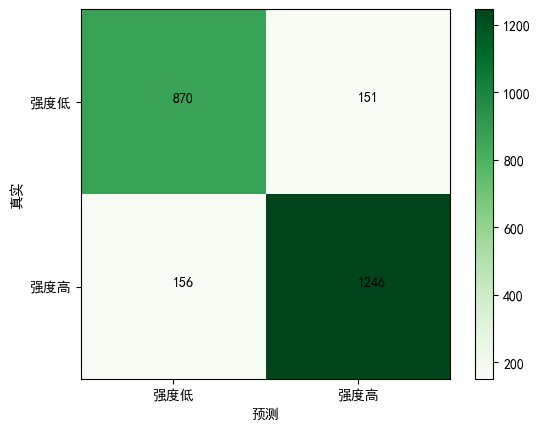

[arousal测试] accuracy:0.8733 precision:0.8733 recall:0.8733 f1:0.8733
=====FOLD_3=====
=====情绪识别任务训练开始=====
=====valence=====


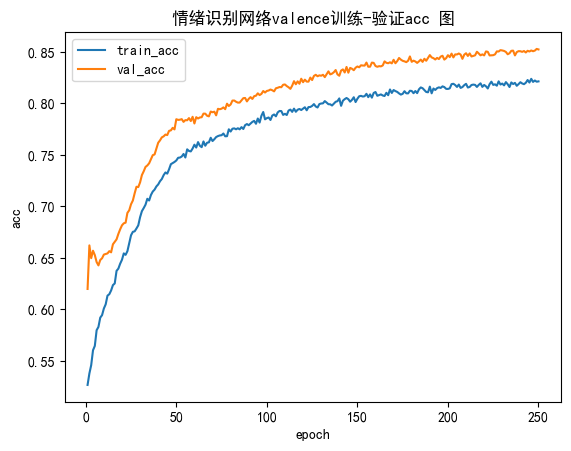

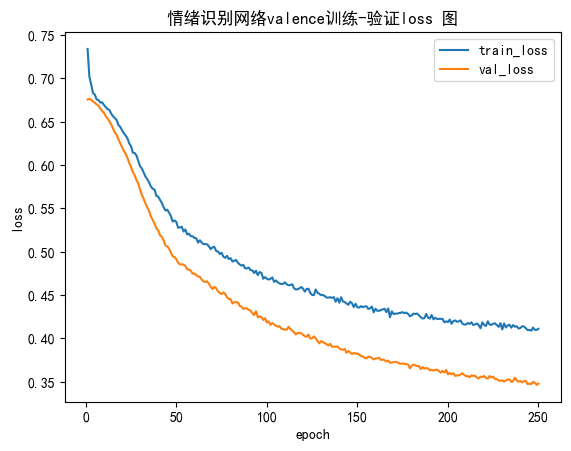

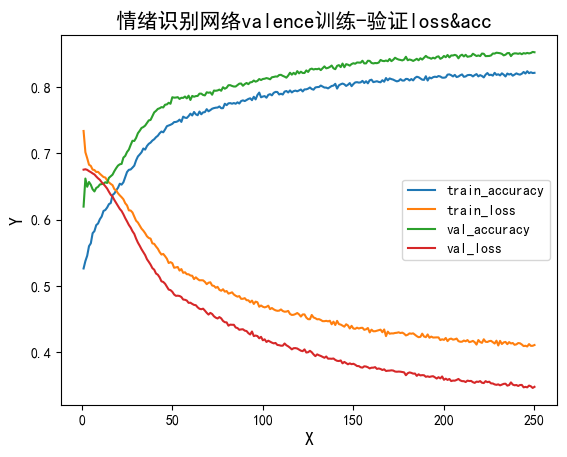

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1320
           1       0.87      0.79      0.83      1103

    accuracy                           0.85      2423
   macro avg       0.86      0.85      0.85      2423
weighted avg       0.85      0.85      0.85      2423

[[1191  129]
 [ 228  875]]


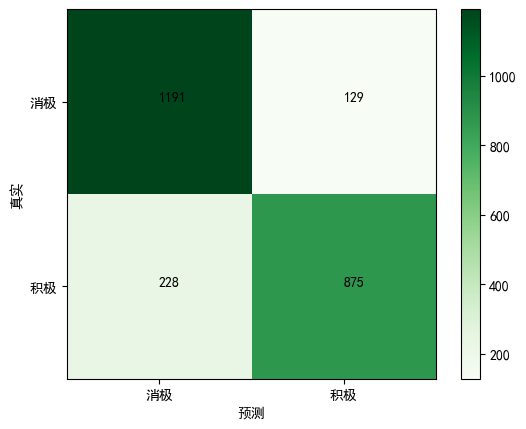

[valence测试] accuracy:0.8527 precision:0.8527 recall:0.8527 f1:0.8527
=====arousal=====


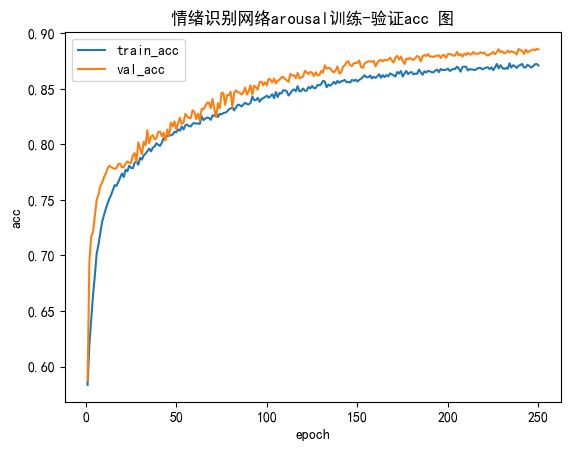

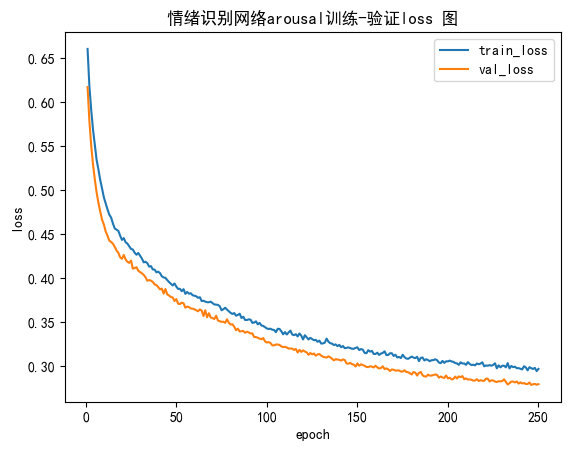

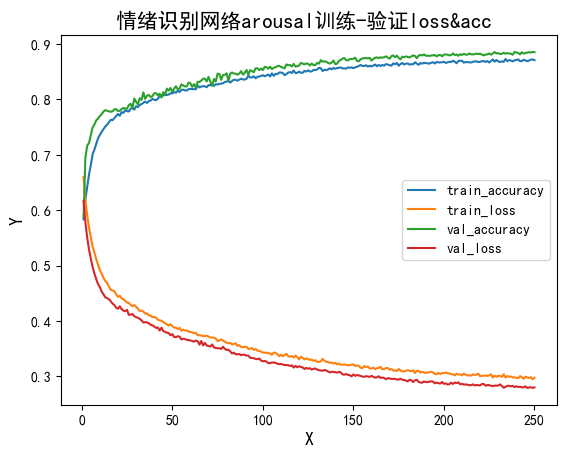

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1002
           1       0.90      0.90      0.90      1421

    accuracy                           0.89      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.89      0.89      0.89      2423

[[ 863  139]
 [ 138 1283]]


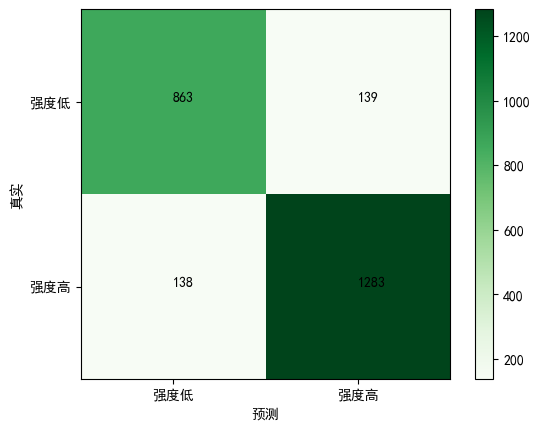

[arousal测试] accuracy:0.8857 precision:0.8857 recall:0.8857 f1:0.8857
保存最优arousal模型model 3
=====FOLD_4=====
=====情绪识别任务训练开始=====
=====valence=====


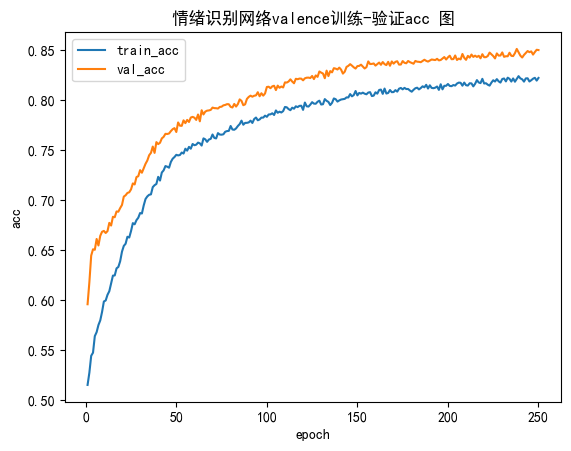

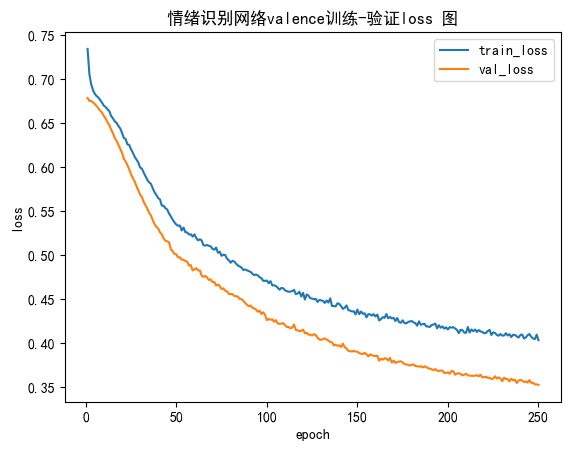

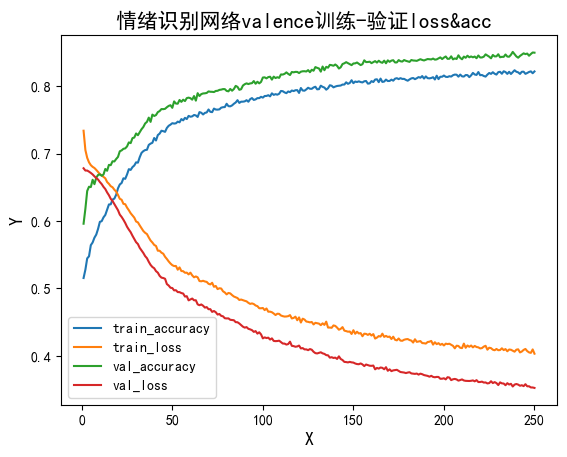

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1320
           1       0.85      0.80      0.83      1103

    accuracy                           0.85      2423
   macro avg       0.85      0.84      0.85      2423
weighted avg       0.85      0.85      0.85      2423

[[1169  151]
 [ 216  887]]


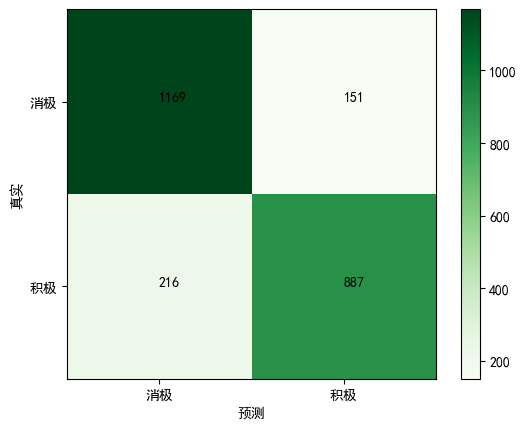

[valence测试] accuracy:0.8485 precision:0.8485 recall:0.8485 f1:0.8485
=====arousal=====


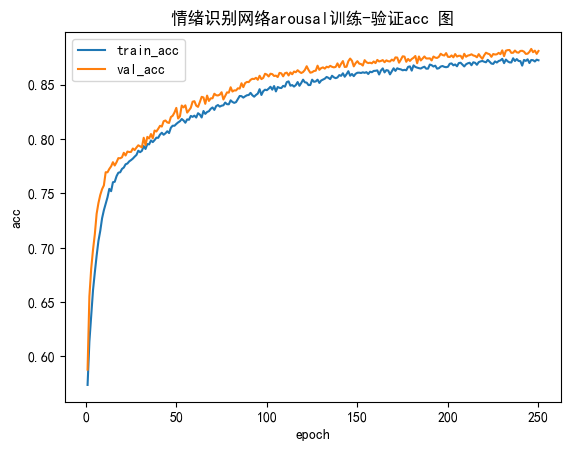

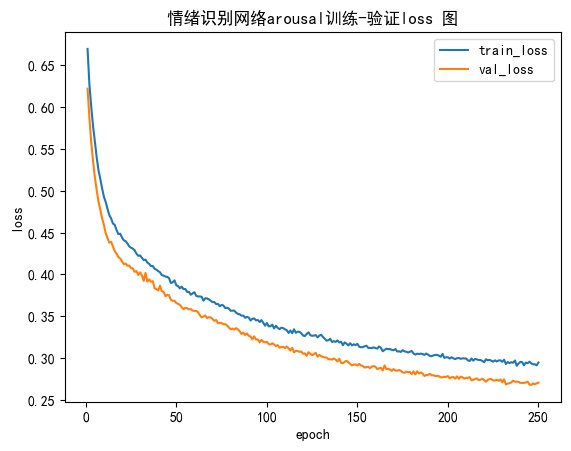

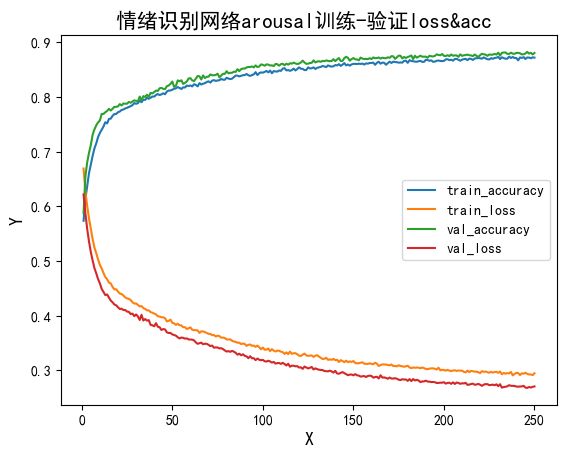

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       996
           1       0.90      0.89      0.90      1427

    accuracy                           0.88      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.88      0.88      0.88      2423

[[ 861  135]
 [ 150 1277]]


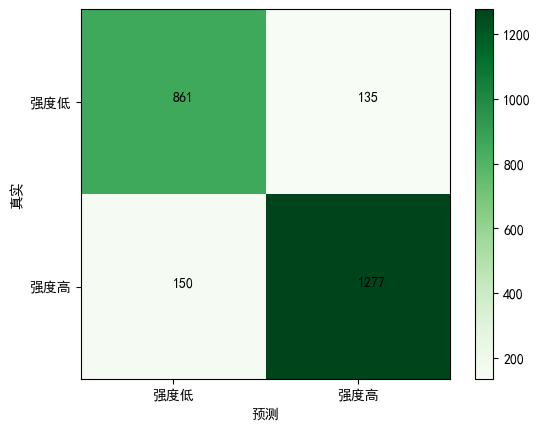

[arousal测试] accuracy:0.8824 precision:0.8824 recall:0.8824 f1:0.8824
=====FOLD_5=====
=====情绪识别任务训练开始=====
=====valence=====


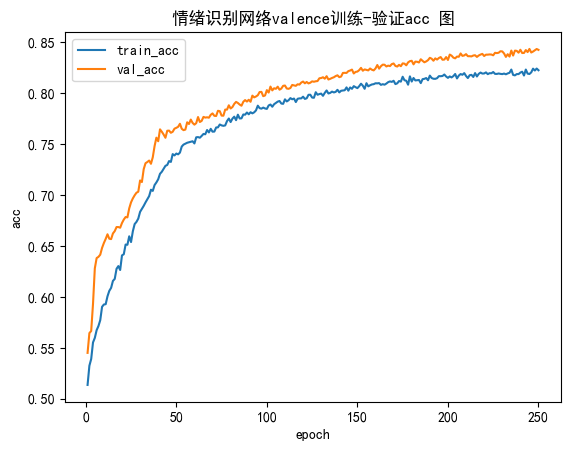

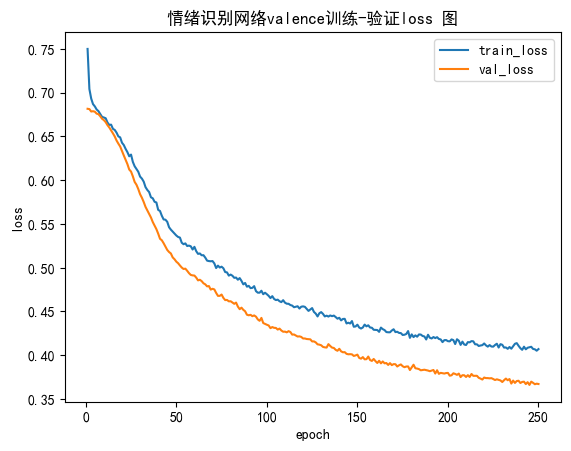

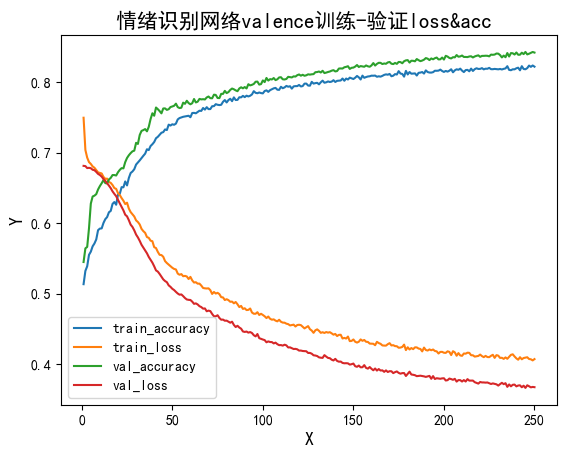

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1320
           1       0.85      0.79      0.82      1103

    accuracy                           0.84      2423
   macro avg       0.84      0.84      0.84      2423
weighted avg       0.84      0.84      0.84      2423

[[1168  152]
 [ 230  873]]


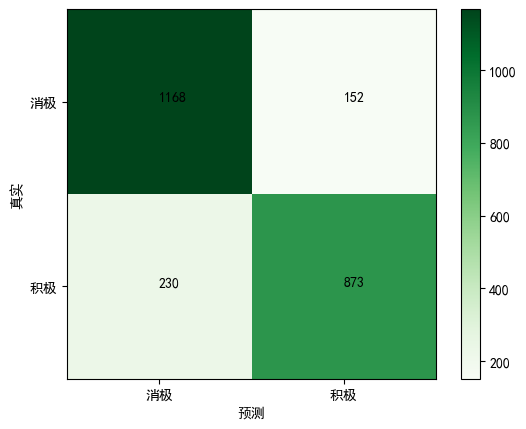

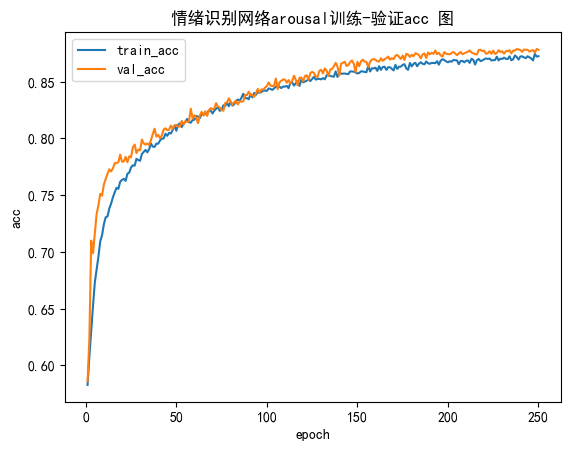

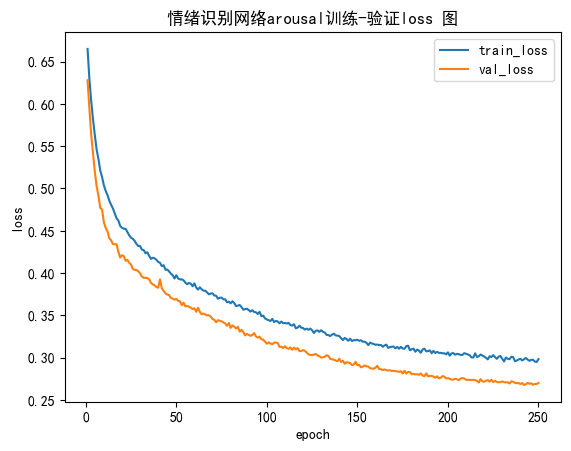

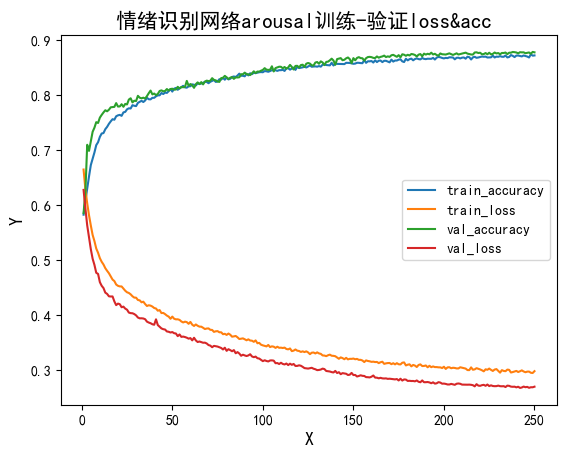

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1006
           1       0.91      0.89      0.90      1417

    accuracy                           0.88      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.88      0.88      0.88      2423

[[ 877  129]
 [ 162 1255]]


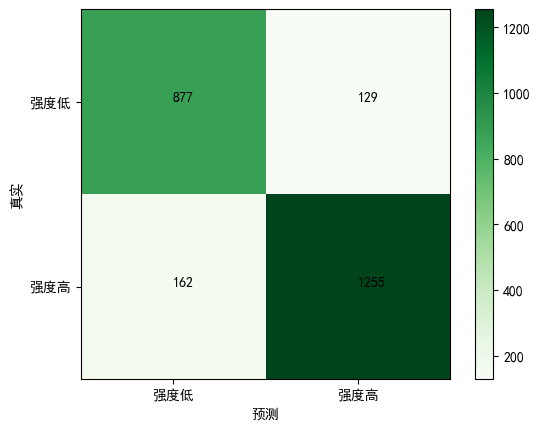

[arousal测试] accuracy:0.8799 precision:0.8799 recall:0.8799 f1:0.8799
=====FOLD_6=====
=====情绪识别任务训练开始=====
=====valence=====


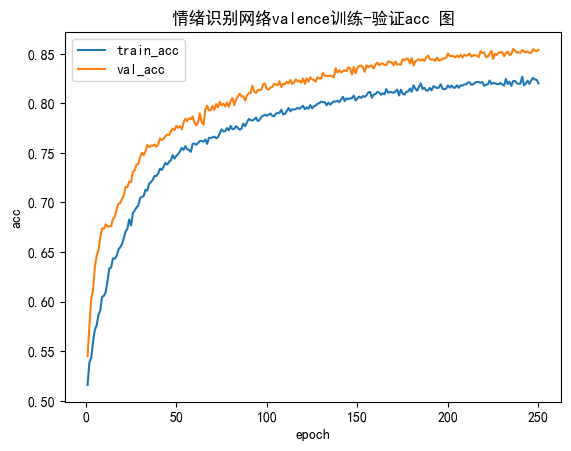

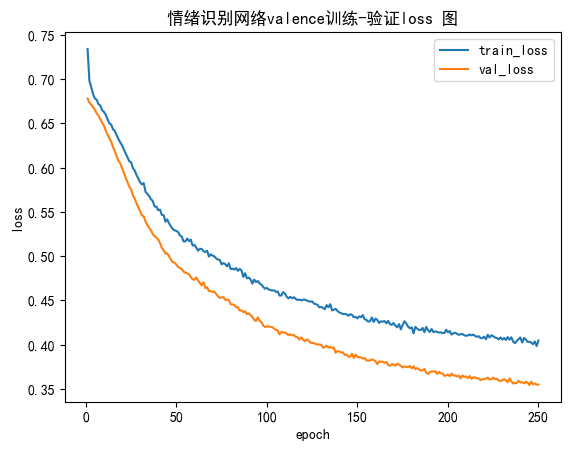

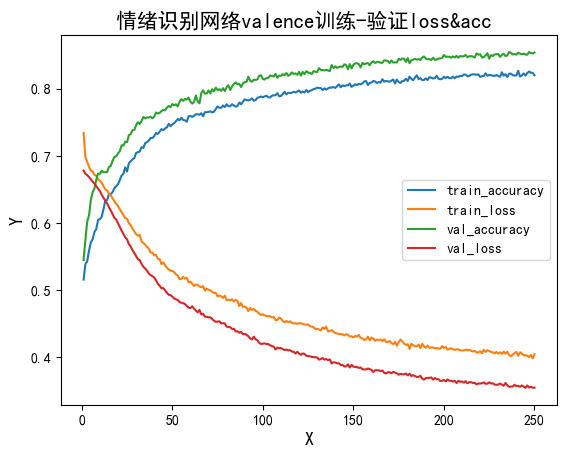

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1320
           1       0.86      0.82      0.84      1103

    accuracy                           0.85      2423
   macro avg       0.85      0.85      0.85      2423
weighted avg       0.85      0.85      0.85      2423

[[1168  152]
 [ 203  900]]


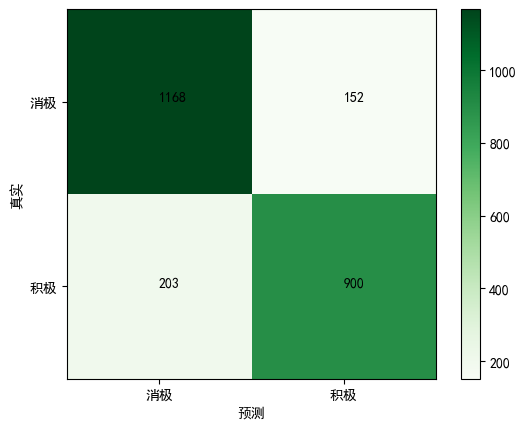

[valence测试] accuracy:0.8535 precision:0.8535 recall:0.8535 f1:0.8535
=====arousal=====


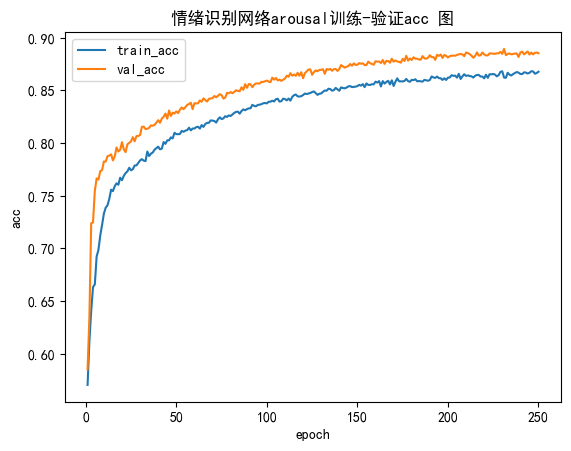

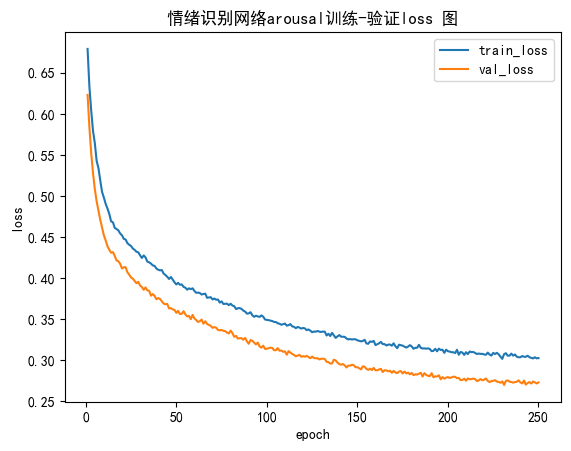

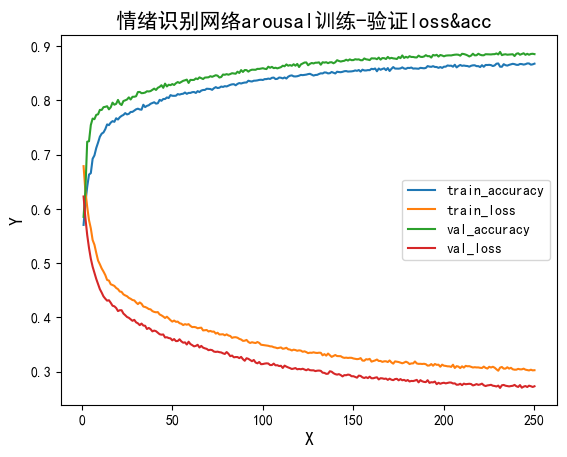

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1005
           1       0.92      0.89      0.90      1418

    accuracy                           0.89      2423
   macro avg       0.88      0.89      0.88      2423
weighted avg       0.89      0.89      0.89      2423

[[ 890  115]
 [ 159 1259]]


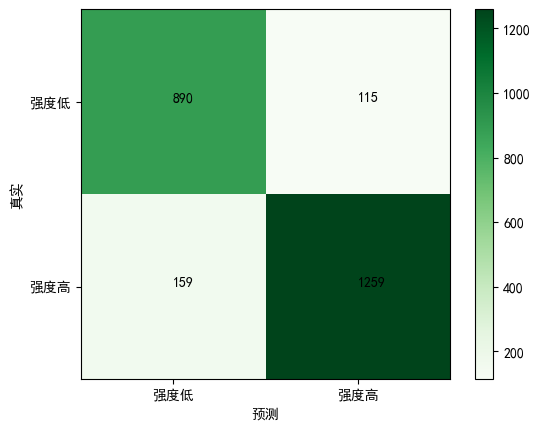

[arousal测试] accuracy:0.8869 precision:0.8869 recall:0.8869 f1:0.8869
保存最优arousal模型model 6
=====FOLD_7=====
=====情绪识别任务训练开始=====
=====valence=====


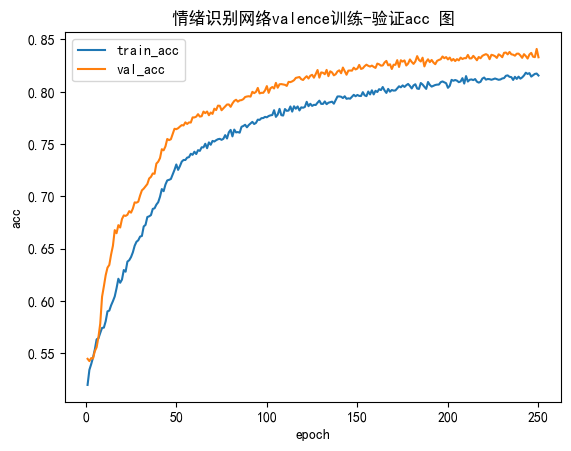

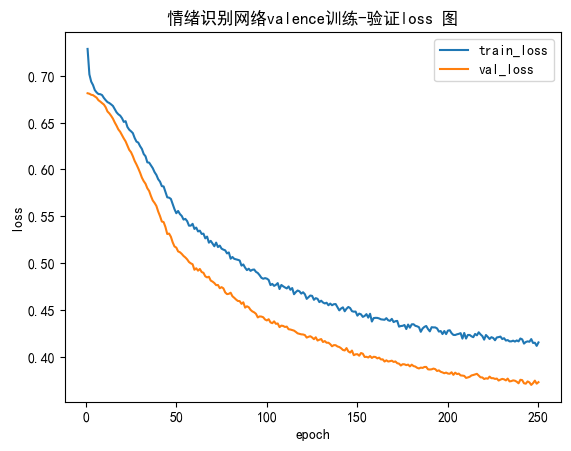

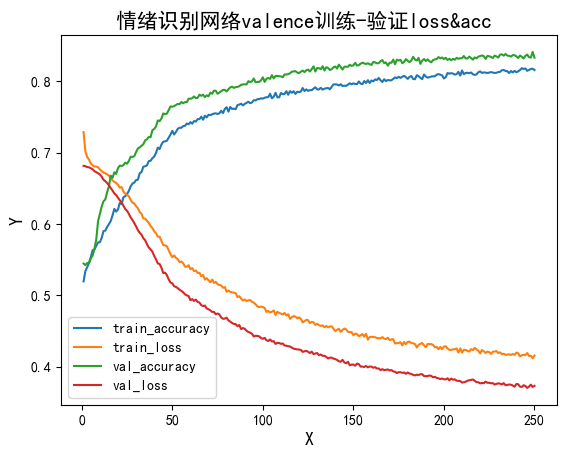

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1319
           1       0.85      0.77      0.81      1103

    accuracy                           0.83      2422
   macro avg       0.84      0.83      0.83      2422
weighted avg       0.83      0.83      0.83      2422

[[1168  151]
 [ 253  850]]


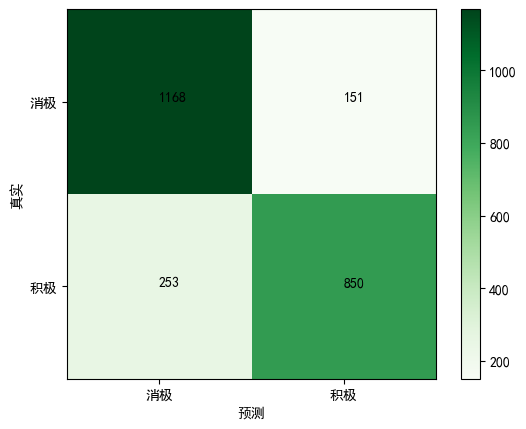

[valence测试] accuracy:0.8332 precision:0.8332 recall:0.8332 f1:0.8332
=====arousal=====


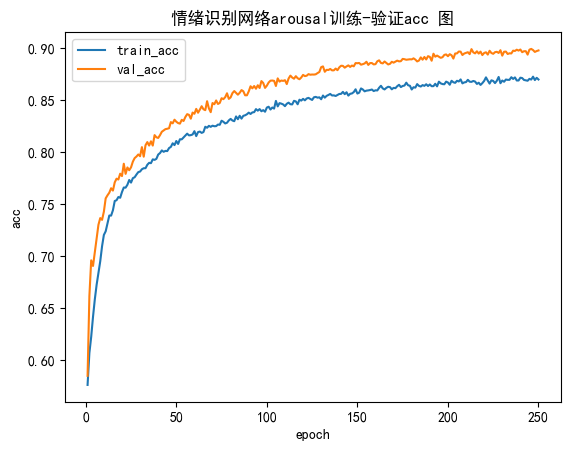

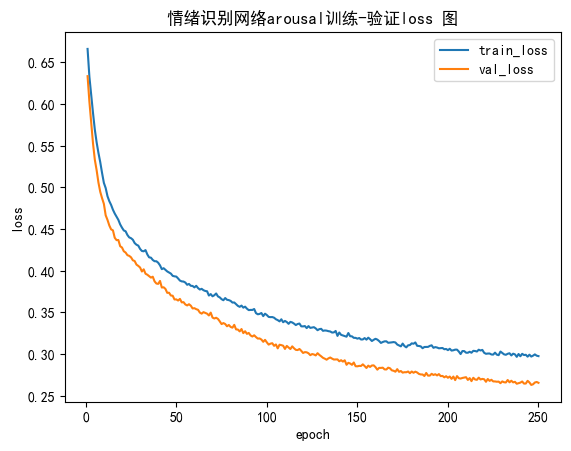

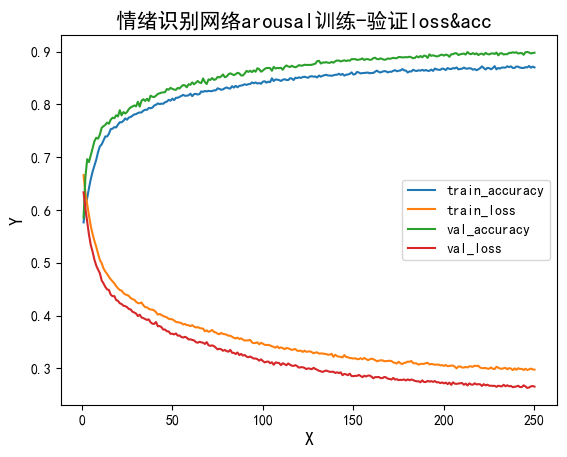

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1003
           1       0.92      0.91      0.91      1420

    accuracy                           0.90      2423
   macro avg       0.90      0.90      0.90      2423
weighted avg       0.90      0.90      0.90      2423

[[ 890  113]
 [ 132 1288]]


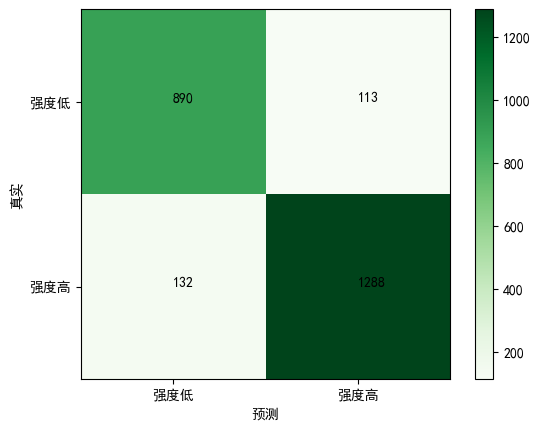

[arousal测试] accuracy:0.8989 precision:0.8989 recall:0.8989 f1:0.8989
保存最优arousal模型model 7
=====FOLD_8=====
=====情绪识别任务训练开始=====
=====valence=====


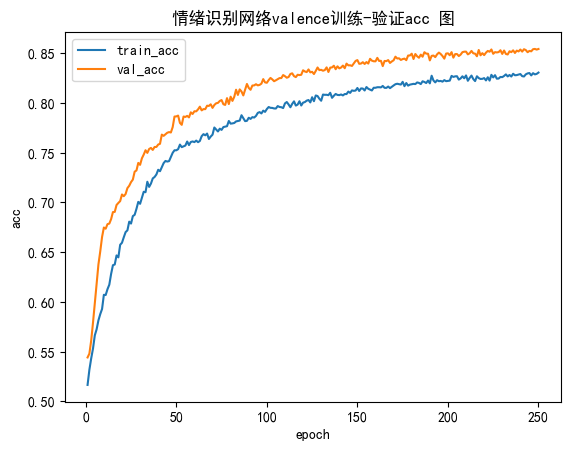

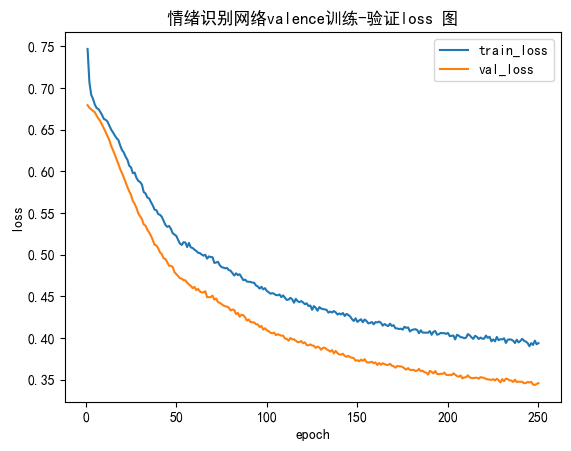

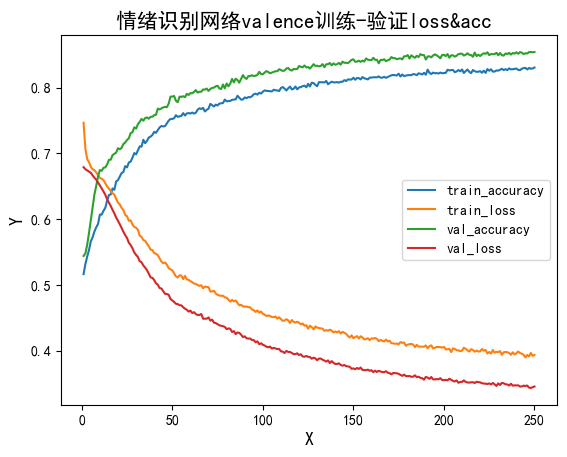

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1319
           1       0.86      0.81      0.83      1103

    accuracy                           0.85      2422
   macro avg       0.85      0.85      0.85      2422
weighted avg       0.85      0.85      0.85      2422

[[1174  145]
 [ 212  891]]


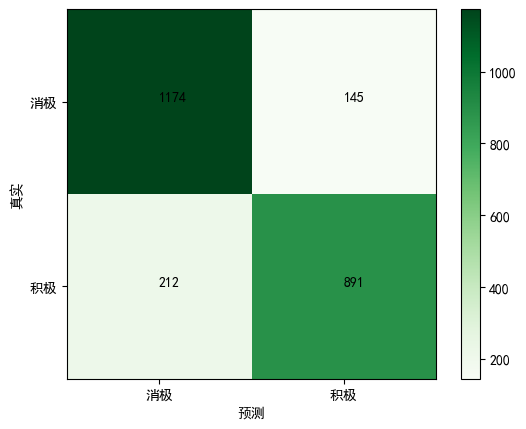

[valence测试] accuracy:0.8526 precision:0.8526 recall:0.8526 f1:0.8526
=====arousal=====


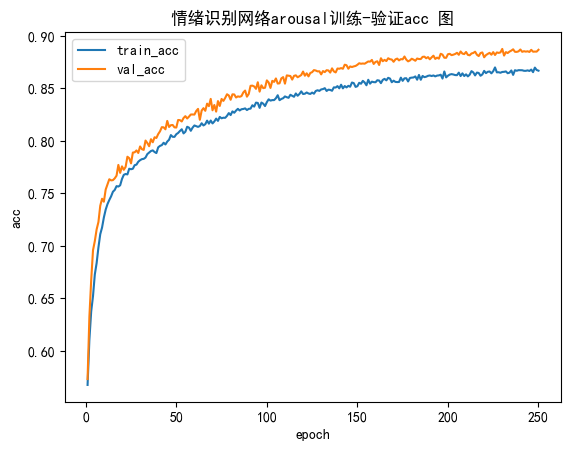

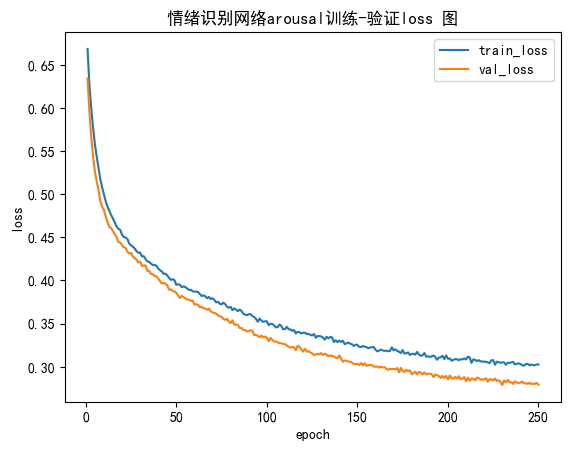

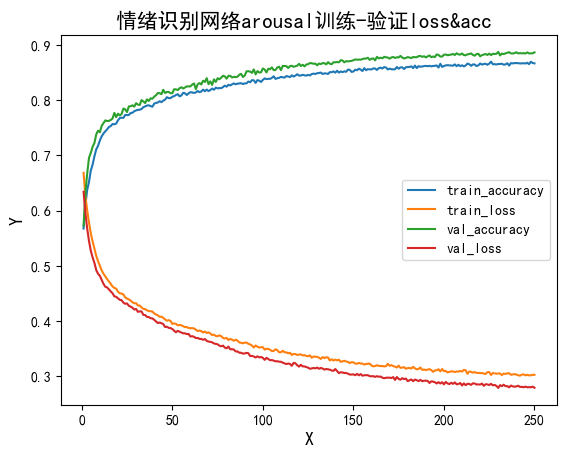

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1037
           1       0.90      0.90      0.90      1386

    accuracy                           0.89      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.89      0.89      0.89      2423

[[ 901  136]
 [ 139 1247]]


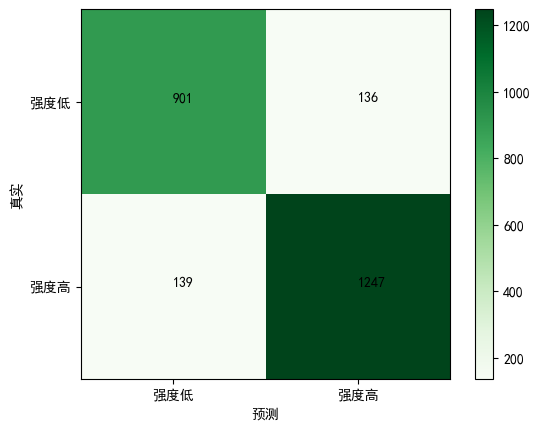

[arousal测试] accuracy:0.8865 precision:0.8865 recall:0.8865 f1:0.8865
=====FOLD_9=====
=====情绪识别任务训练开始=====
=====valence=====


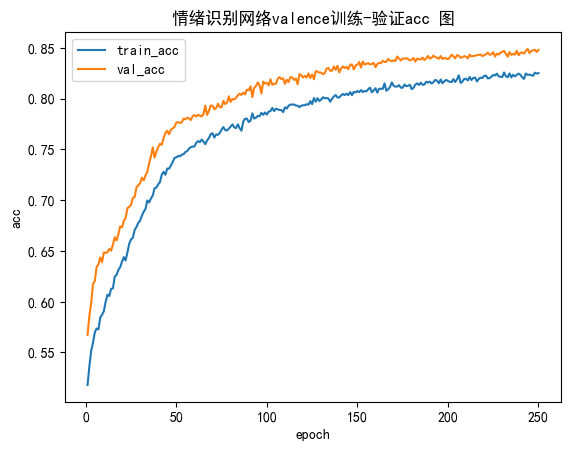

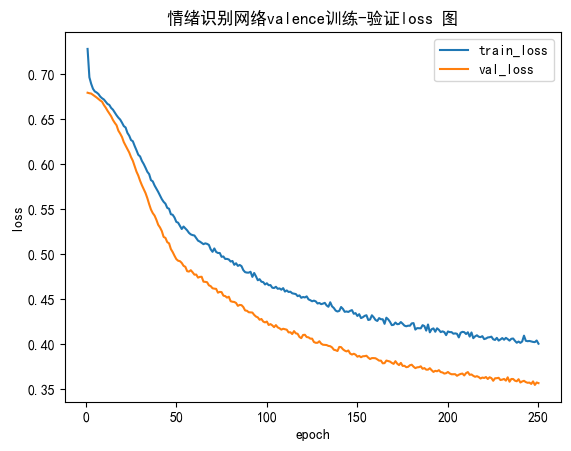

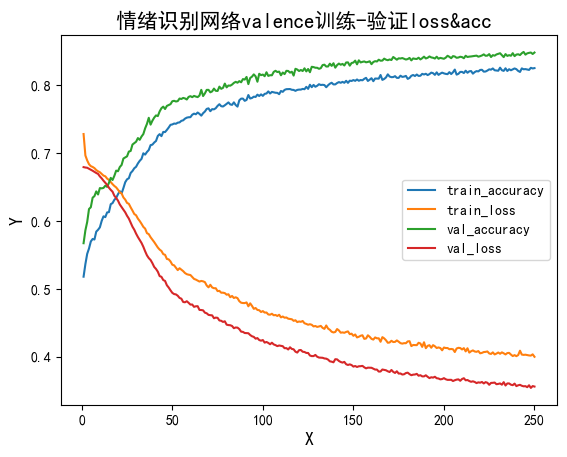

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1319
           1       0.86      0.80      0.83      1103

    accuracy                           0.85      2422
   macro avg       0.85      0.84      0.85      2422
weighted avg       0.85      0.85      0.85      2422

[[1170  149]
 [ 218  885]]


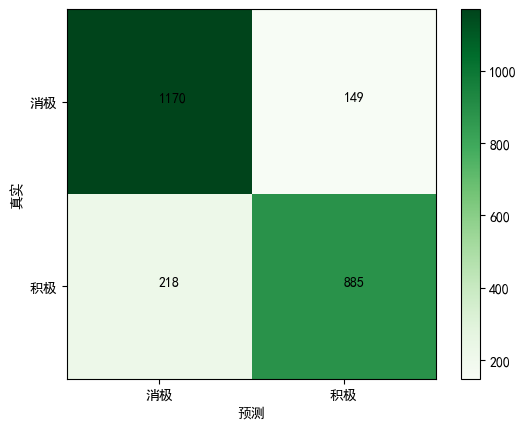

[valence测试] accuracy:0.8485 precision:0.8485 recall:0.8485 f1:0.8485
=====arousal=====


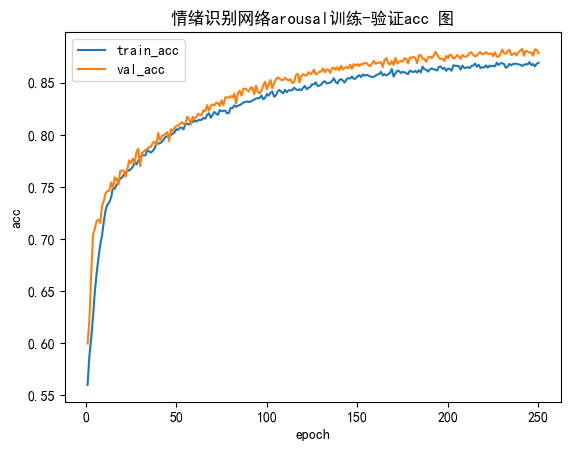

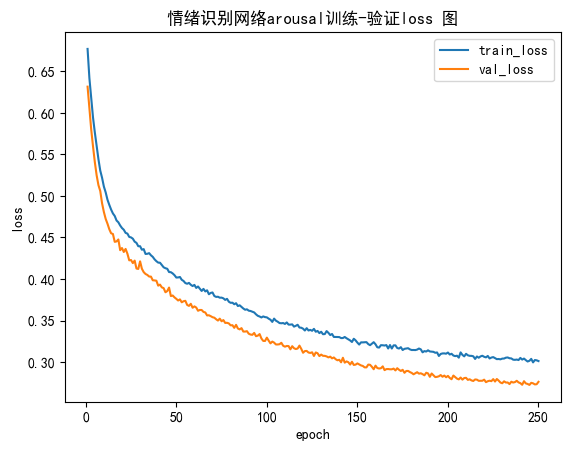

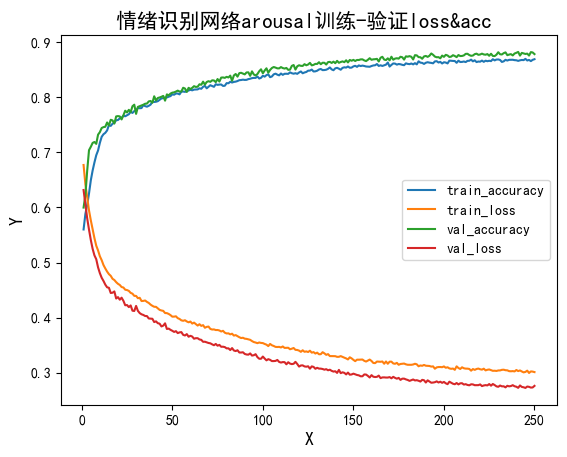

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       969
           1       0.92      0.88      0.90      1453

    accuracy                           0.88      2422
   macro avg       0.87      0.88      0.88      2422
weighted avg       0.88      0.88      0.88      2422

[[ 854  115]
 [ 176 1277]]


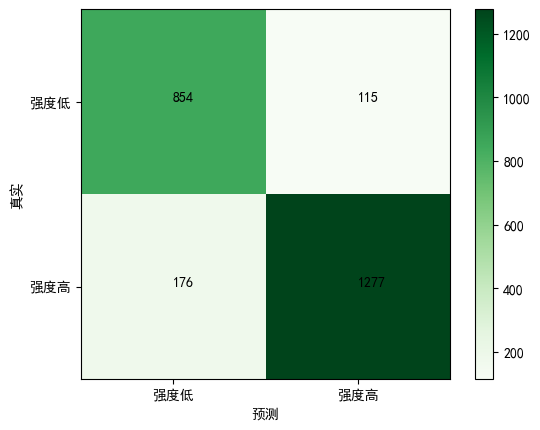

[arousal测试] accuracy:0.8799 precision:0.8799 recall:0.8799 f1:0.8799


In [27]:
#训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3]

model1 = []
model2 = []
model3 = []
model4 = []
best_acc1,best_acc2,best_acc3 = 0.0,0.0,0.0


print("=====开始训练网络=====")

for k in range(total_fold):
    train_acc1,train_losses1,test_acc1,test_losses1,train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], [], [], [], [], []
    
    print("=====FOLD_{}=====".format(k))
    train_ECG = np.vstack((load_data_v[train_index_positive[k],1:], load_data_v[train_index_negative[k],1:]))
    
    test_ECG = np.vstack((load_data_v[test_index_positive[k],1:], load_data_v[test_index_negative[k],1:]))
    
    train_label = np.hstack((load_data_v[train_index_positive[k],0], load_data_v[train_index_negative[k],0]))
    
    test_label = np.hstack((load_data_v[test_index_positive[k],0], load_data_v[test_index_negative[k],0]))
    
    train_ECG_a = np.vstack((load_data_a[train_index_0[k],1:], load_data_a[train_index_1[k],1:]))
    
    test_ECG_a = np.vstack((load_data_a[test_index_0[k],1:], load_data_a[test_index_1[k],1:]))
    
    train_label_a = np.hstack((load_data_a[train_index_0[k],0], load_data_a[train_index_1[k],0]))
    
    test_label_a = np.hstack((load_data_a[test_index_0[k],0], load_data_a[test_index_1[k],0]))
    
    #net init
    #model = model_CNN().to(device)
    model = model_CNN()
    
    model.to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)#init weight
    
    pre_weights = torch.load('/home/whh/lt/models/pretask_best_model1', map_location='cuda')  # 读取参数\
    model.load_state_dict(pre_weights)  # 将参数载入到模型
    
    model1.append(model)
    
    model= model_Task().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model2.append(model)
    
    model= model_valence().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model3.append(model)
    
    model= model_arousal().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model4.append(model)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(),lr=0.0001)#learning rate too large?
    #optimizer = optim.Adam(model1[k].parameters(),lr=initial_learning_rate)
    optimizer = torch.optim.SGD(model1[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer2 = optim.Adam(model2[k].parameters(),lr=initial_learning_rate)
    optimizer2 = torch.optim.SGD(model2[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer3 = optim.Adam(model3[k].parameters(),lr=initial_learning_rate)
    optimizer3 = torch.optim.SGD(model3[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=50, gamma=0.6)
    
    #optimizer4 = optim.Adam(model4[k].parameters(),lr=initial_learning_rate)
    optimizer4 = torch.optim.SGD(model4[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler4 = optim.lr_scheduler.StepLR(optimizer4, step_size=50, gamma=0.6)
    
    training_length = len(train_ECG)
    testing_length = len(test_ECG)
    
    
    
#     print("=====辅助任务训练开始=====")
#     # epoch loop
#     for epoch_counter in range(t_epoch):#only 100 times
#         start = time.time()

# #         tr_loss_task = np.zeros((len(transform_task), 1), dtype  = np.float32)
# #         train_pred_task = np.zeros((len(transform_task), actual_batch_size), dtype  = np.float32) -1
# #         train_true_task = np.zeros((len(transform_task), actual_batch_size), dtype  = np.float32) -1
# #         tr_output_loss = 0
        
#         model1[k].train()
#         model2[k].train()

#         running_loss = 0.0
#         train_a = 0.0
#         train_preds = []
#         train_trues = []

#         tr_total_gen_op = make_total_batch(data = train_ECG, length = training_length, batchsize = batchsize, 
#                                                    noise_amount=noise_param, 
#                                                    scaling_factor=scale_param, 
#                                                    permutation_pieces=permu_param)
        
#         for training_batch, training_labels, tr_counter, tr_steps in tr_total_gen_op:  
#             ## run the model here

#             inputs = np.asarray(training_batch)
#             labels = np.asarray(training_labels)
#             labels = labels.reshape(labels.shape[0])
#             inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)
#             predictions = model1[k](inputs)
#             predictions = model2[k](predictions)

#             loss = criterion(predictions,labels.long())
#             optimizer.zero_grad()
#             optimizer2.zero_grad()
#             loss.backward()
#             optimizer.step()
#             optimizer2.step()


#             running_loss += loss.data
#             train_outputs = predictions.data.cpu().argmax(dim=1)
#             acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
#             train_a += acc.item()

#             train_preds.extend(train_outputs.detach().cpu().numpy())
#             train_trues.extend(labels.detach().cpu().numpy())


#         sklearn_accuracy = accuracy_score(train_trues, train_preds) 
#         sklearn_precision = precision_score(train_trues, train_preds, average='micro')
#         sklearn_recall = recall_score(train_trues, train_preds, average='micro')
#         sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
#         train_loss = running_loss.cpu() / (tr_counter+1)
#         train_a = train_a / (tr_counter+1)
#         print("[信号转换-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter, train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
#         train_acc1.append(train_a)
#         train_losses1.append(train_loss)

#         scheduler.step()
#         scheduler2.step()
        
        
#         #val    
#         model1[k].eval()
#         model2[k].eval()
        
#         running_loss = 0.0
#         test_a = 0.0
#         test_preds = []
#         test_trues = []
#         #print("=====开始测试辅助任务网络=====")
#         te_total_gen_op = make_total_batch(data = test_ECG,length = testing_length, batchsize = batchsize, 
#                                             noise_amount=noise_param, 
#                                             scaling_factor=scale_param, 
#                                             permutation_pieces=permu_param)

#         with torch.no_grad():
#             for testing_batch, testing_labels, te_counter, te_steps in te_total_gen_op:  
#                 ## run the model here

#                 inputs = np.asarray(testing_batch)
#                 labels = np.asarray(testing_labels)
#                 labels = labels.reshape(labels.shape[0])
#                 inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)
#                 predictions = model1[k](inputs)
#                 predictions = model2[k](predictions)
                
#                 loss = criterion(predictions,labels.long())
                
#                 running_loss += loss.data
#                 test_outputs = predictions.data.cpu().argmax(dim=1)
#                 acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
#                 test_a += acc.item()

#                 test_preds.extend(test_outputs.detach().cpu().numpy())
#                 test_trues.extend(labels.detach().cpu().numpy())

#             sklearn_accuracy = accuracy_score(test_trues, test_preds)
#             sklearn_precision = precision_score(test_trues, test_preds, average='micro')
#             sklearn_recall = recall_score(test_trues, test_preds, average='micro')
#             sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
#             test_loss = running_loss.cpu() / (te_counter+1)
#             test_a = test_a / (te_counter+1)
#             print("[信号转换-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
#             test_acc1.append(test_a)
#             test_losses1.append(test_loss)

        
#         end = time.time()
#         print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
#     #plot pic
#     plot_all(t_epoch, train_acc1, train_losses1, test_acc1, test_losses1,"信号转换识别网络训练-验证")
    
#     print(classification_report(test_trues, test_preds))
#     conf_matrix = get_confusion_matrix(test_trues, test_preds)
#     print(conf_matrix)
#     plot_confusion_matrix(conf_matrix)
#     print("[信号转换识别网络测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

    
#     #print("=====辅助任务训练结束=====")
    
#     # 保存模型?
#     if sklearn_precision > best_acc1:
#         print("保存最优信号转换模型model",k)
#         torch.save(model1[k].state_dict(),"/home/whh/lt/models/pretask_best_model1")# 只保存模型参数
#         torch.save(model2[k].state_dict(),"/home/whh/lt/models/pretask_best_model2")
#         best_acc1 = sklearn_precision
    
    
    print("=====情绪识别任务训练开始=====")
    print("=====valence=====")
    for epoch_counter in range(epoch):
        start = time.time()
        
        
        #ssl down stream task
        model1[k].eval()
        #model1[k].train()
        model3[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG,train_label)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model3[k](predictions)

            loss = criterion(predictions,labels.long())
            #optimizer.zero_grad()
            optimizer3.zero_grad()
            loss.backward()
            #optimizer.step()
            optimizer3.step()


            running_loss += loss.data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[valence-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        
        #scheduler.step()
        scheduler3.step()
        
        #print("=====情绪识别训练结束=====")
        #down test
        model1[k].eval()
        model3[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试情绪识别valence任务网络=====")
        test_data = MyData(test_ECG,test_label)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model3[k](predictions)
                test_outputs = predictions.data.cpu().argmax(dim=1)

                loss = criterion(predictions,labels.long())
                
                running_loss += loss.data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[valence-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
            
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"情绪识别网络valence训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_valence)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_valence)
    print("[valence测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
        # 保存模型
    if sklearn_precision > best_acc2:
        print("保存最优情绪识别valence模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/valence_best_model1")# 只保存模型参数
        torch.save(model3[k].state_dict(),"/home/whh/lt/models/valence_best_model3")
        best_acc2 = sklearn_precision
    
    print("=====arousal=====")
    
    train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], []
    
    train_ECG = train_ECG_a
    test_ECG = test_ECG_a
    train_label =train_label_a
    test_label = test_label_a
    
    for epoch_counter in range(epoch):
        start = time.time()
        
        
        #ssl down stream task
        model1[k].eval()
        #model1[k].train()
        model4[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG_a,train_label_a)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model4[k](predictions)

            loss = criterion(predictions,labels.long())
            #optimizer.zero_grad()
            optimizer4.zero_grad()
            loss.backward()
            #optimizer.step()
            optimizer4.step()


            running_loss += loss.data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[arousal-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        
        #scheduler.step()
        scheduler4.step()
        
        #print("=====情绪识别训练结束=====")
        #down test
        model1[k].eval()
        model4[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试情绪识别arousal任务网络=====")
        test_data = MyData(test_ECG_a,test_label_a)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model4[k](predictions)
                test_outputs = predictions.data.cpu().argmax(dim=1)

                loss = criterion(predictions,labels.long())
                
                running_loss += loss.data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[arousal-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
            
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"情绪识别网络arousal训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_arousal)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_arousal)
    print("[arousal测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
    # 保存模型
    if sklearn_precision > best_acc3:
        print("保存最优arousal模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/arousal_best_model1")# 只保存模型参数
        torch.save(model4[k].state_dict(),"/home/whh/lt/models/arousal_best_model3")
        best_acc3 = sklearn_precision
    
            

=====开始训练网络=====
=====FOLD_0=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


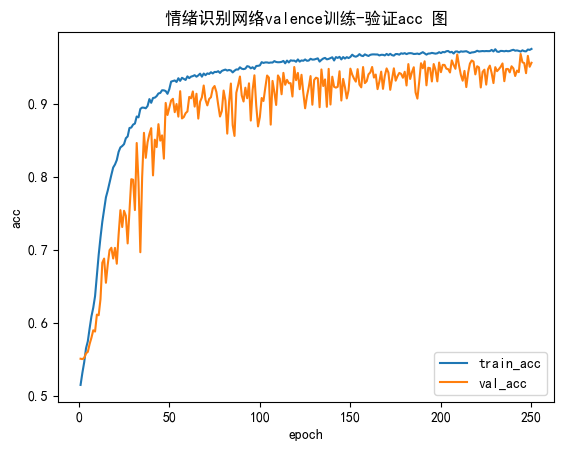

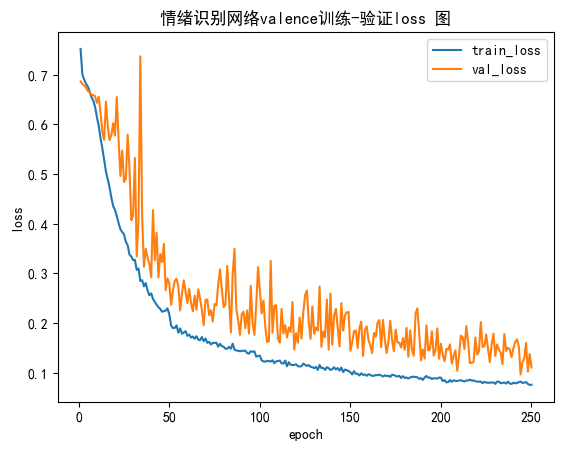

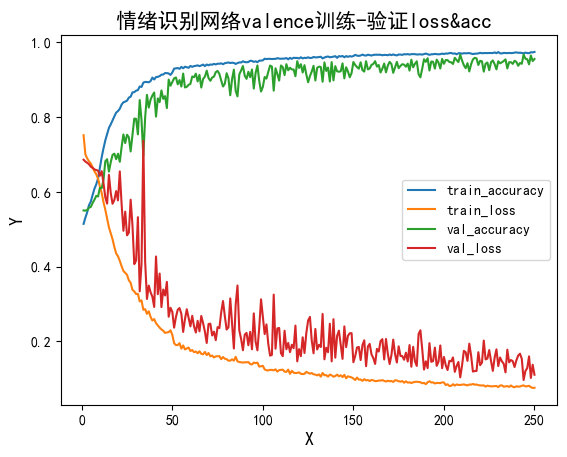

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1320
           1       0.94      0.96      0.95      1104

    accuracy                           0.96      2424
   macro avg       0.95      0.96      0.96      2424
weighted avg       0.96      0.96      0.96      2424

[[1253   67]
 [  40 1064]]


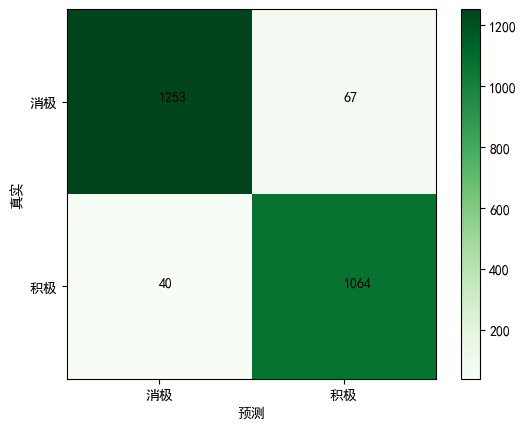

[valence测试] accuracy:0.9559 precision:0.9559 recall:0.9559 f1:0.9559
保存最优情绪识别valence模型model 0
=====arousal=====


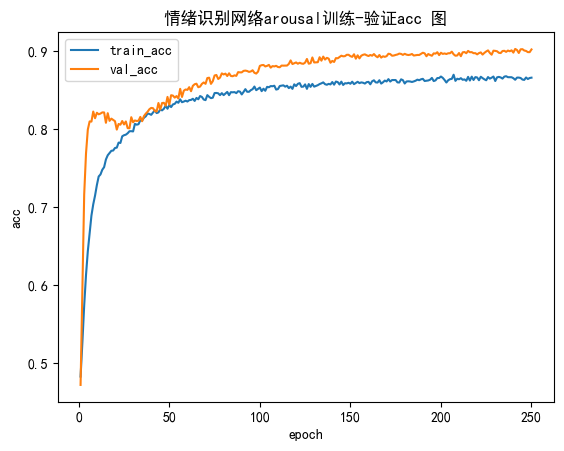

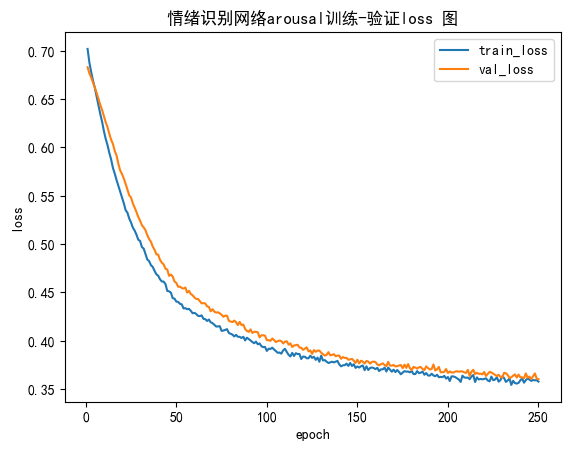

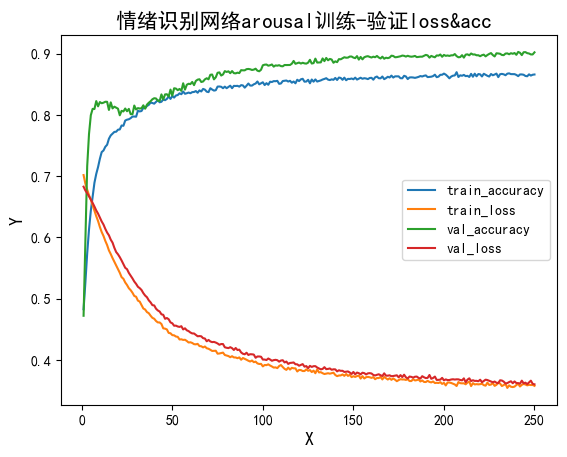

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1015
           1       0.90      0.93      0.92      1409

    accuracy                           0.90      2424
   macro avg       0.90      0.90      0.90      2424
weighted avg       0.90      0.90      0.90      2424

[[ 873  142]
 [  97 1312]]


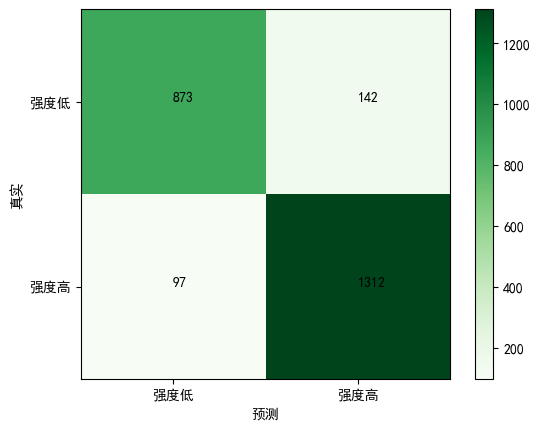

[arousal测试] accuracy:0.9014 precision:0.9014 recall:0.9014 f1:0.9014
保存最优arousal模型model 0
=====FOLD_1=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


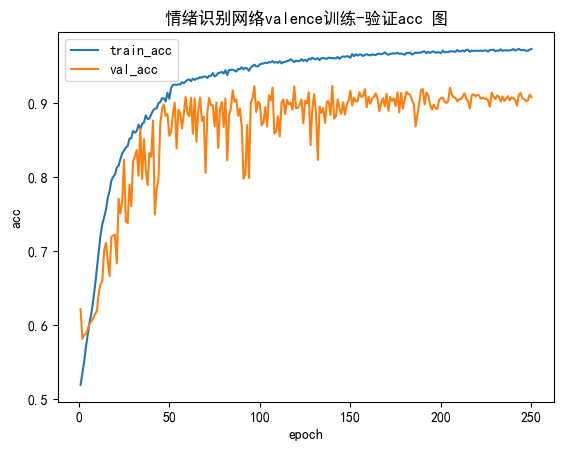

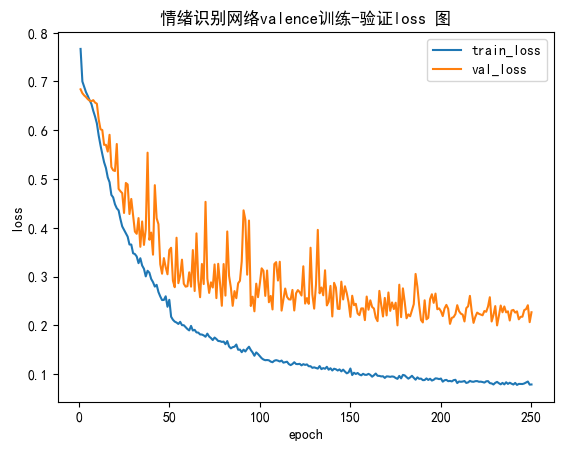

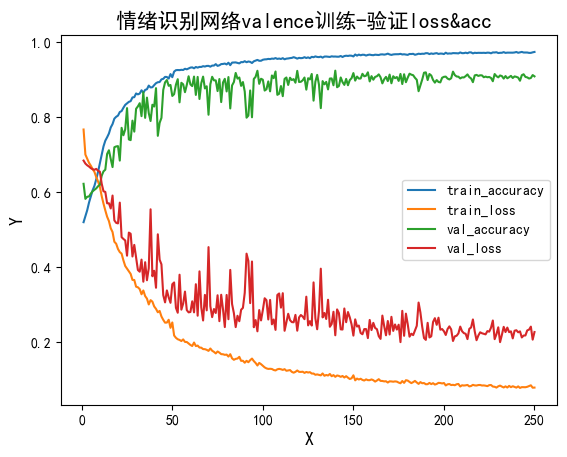

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1320
           1       0.91      0.89      0.90      1104

    accuracy                           0.91      2424
   macro avg       0.91      0.91      0.91      2424
weighted avg       0.91      0.91      0.91      2424

[[1227   93]
 [ 126  978]]


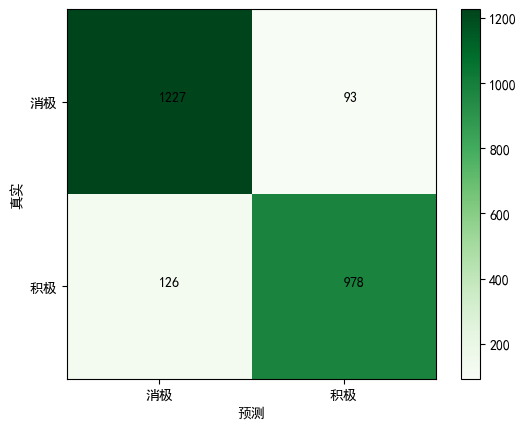

[valence测试] accuracy:0.9097 precision:0.9097 recall:0.9097 f1:0.9097
=====arousal=====


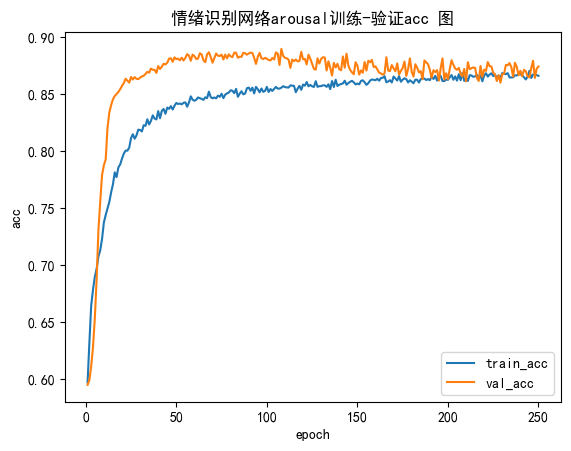

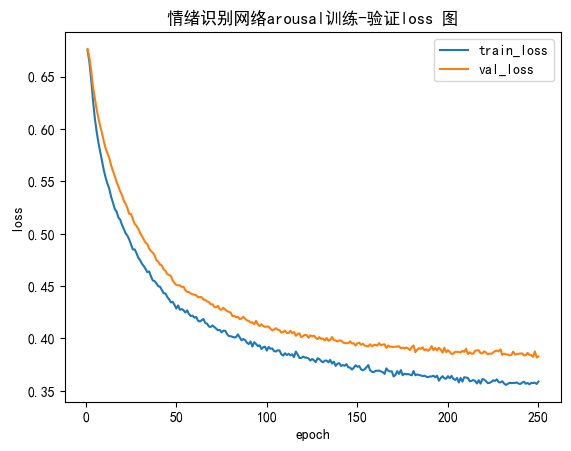

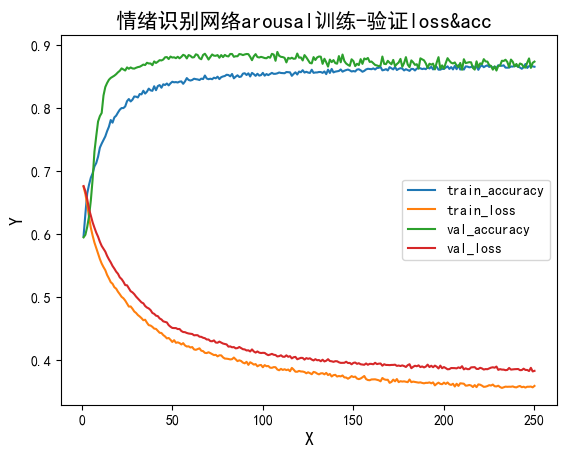

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       985
           1       0.85      0.95      0.90      1438

    accuracy                           0.87      2423
   macro avg       0.88      0.85      0.86      2423
weighted avg       0.88      0.87      0.87      2423

[[ 744  241]
 [  67 1371]]


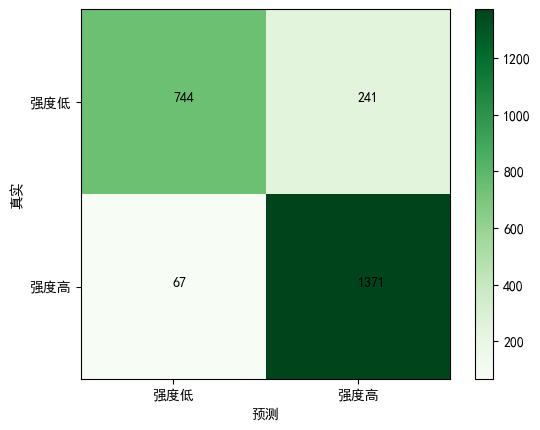

[arousal测试] accuracy:0.8729 precision:0.8729 recall:0.8729 f1:0.8729
=====FOLD_2=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


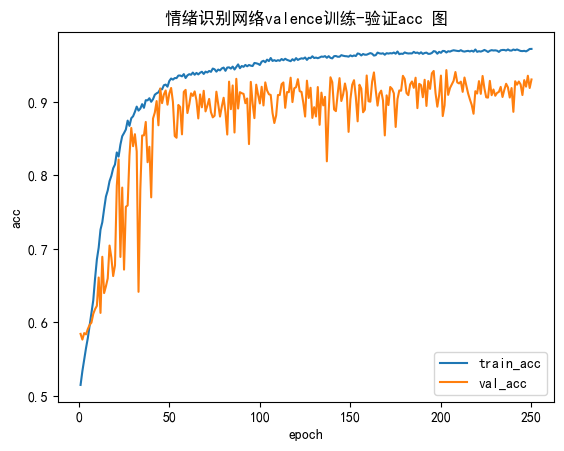

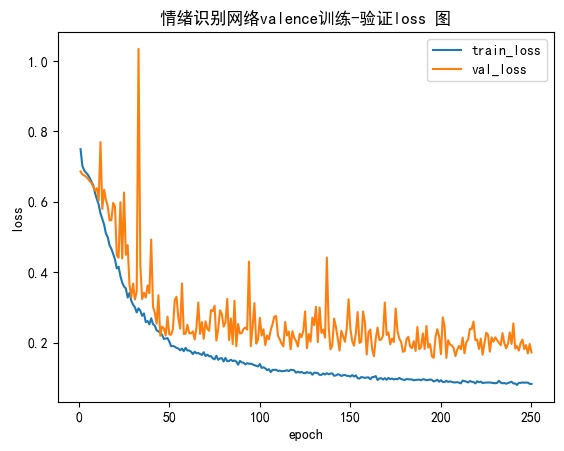

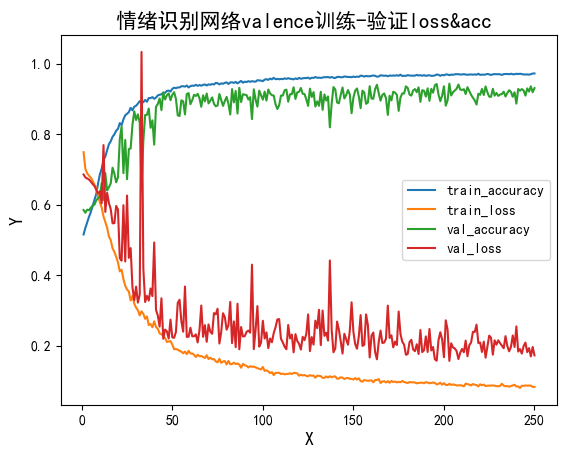

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1320
           1       0.90      0.96      0.93      1104

    accuracy                           0.93      2424
   macro avg       0.93      0.93      0.93      2424
weighted avg       0.93      0.93      0.93      2424

[[1201  119]
 [  46 1058]]


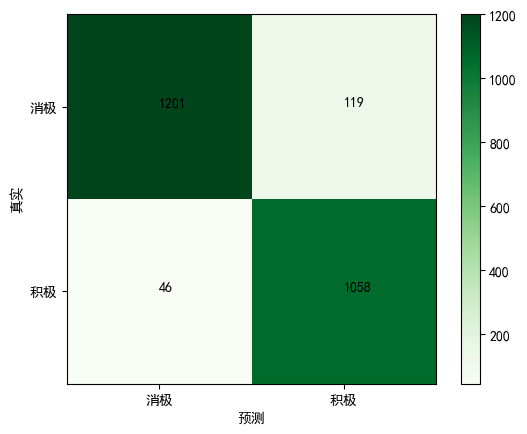

[valence测试] accuracy:0.9319 precision:0.9319 recall:0.9319 f1:0.9319
=====arousal=====


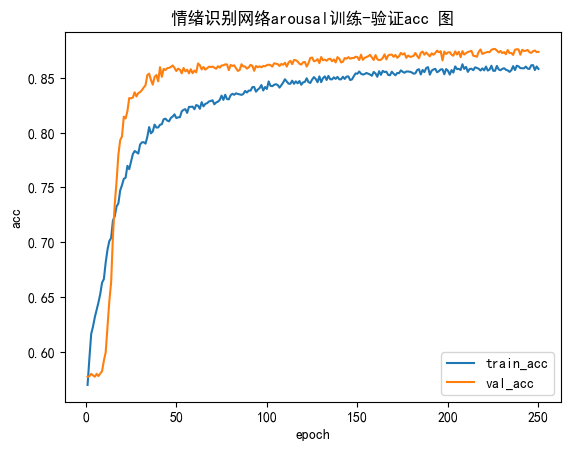

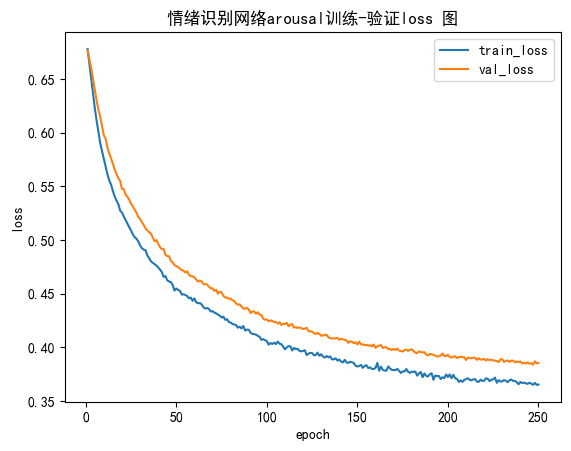

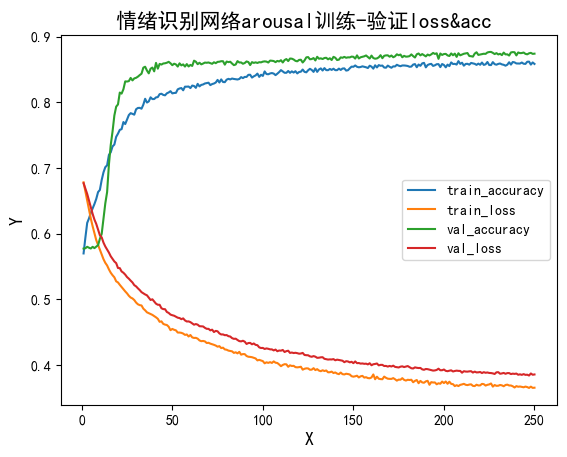

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1021
           1       0.88      0.90      0.89      1402

    accuracy                           0.87      2423
   macro avg       0.87      0.87      0.87      2423
weighted avg       0.87      0.87      0.87      2423

[[ 855  166]
 [ 139 1263]]


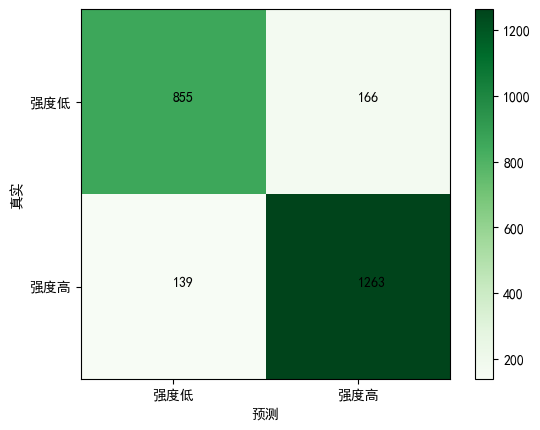

[arousal测试] accuracy:0.8741 precision:0.8741 recall:0.8741 f1:0.8741
=====FOLD_3=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


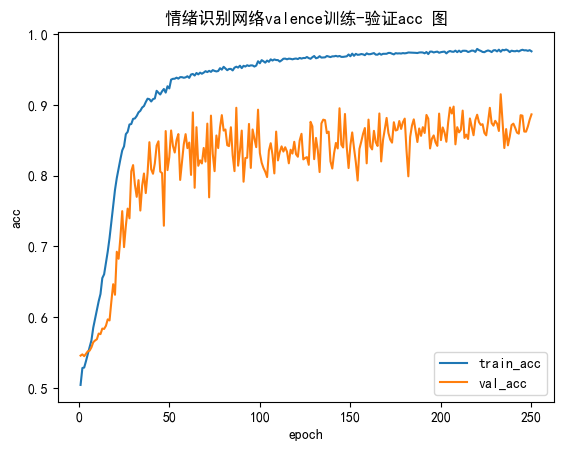

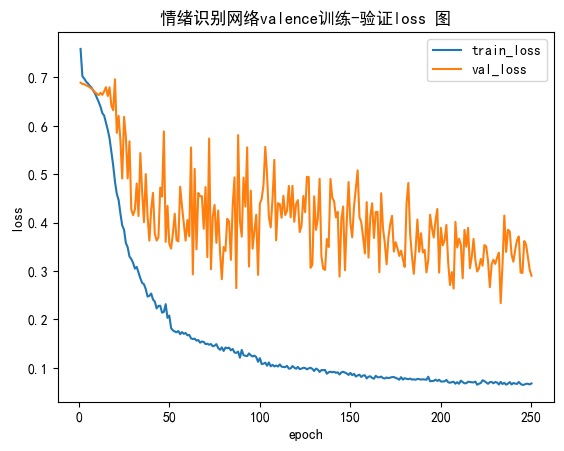

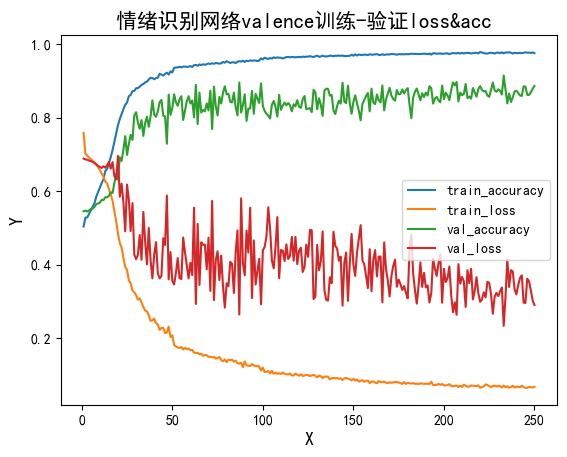

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1320
           1       0.83      0.95      0.88      1103

    accuracy                           0.89      2423
   macro avg       0.89      0.89      0.89      2423
weighted avg       0.89      0.89      0.89      2423

[[1101  219]
 [  59 1044]]


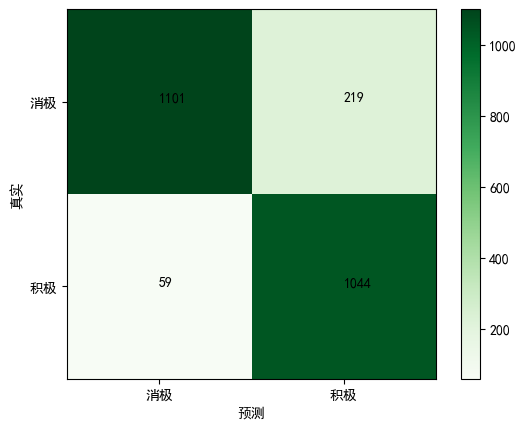

[valence测试] accuracy:0.8853 precision:0.8853 recall:0.8853 f1:0.8853
=====arousal=====


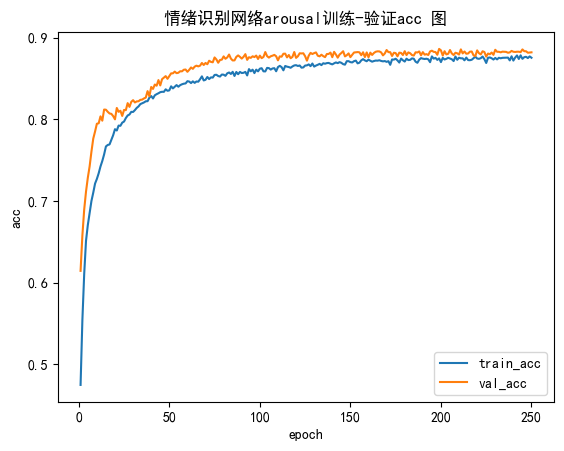

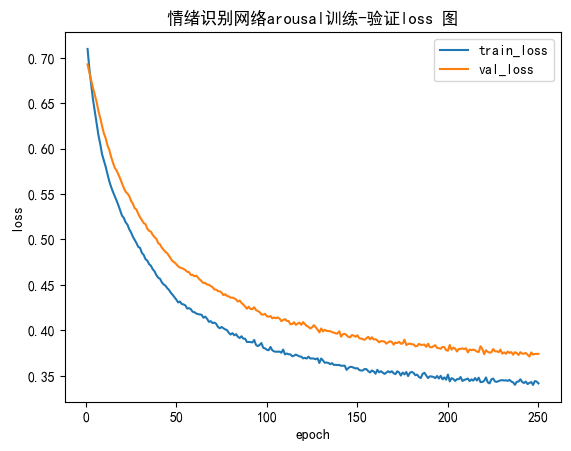

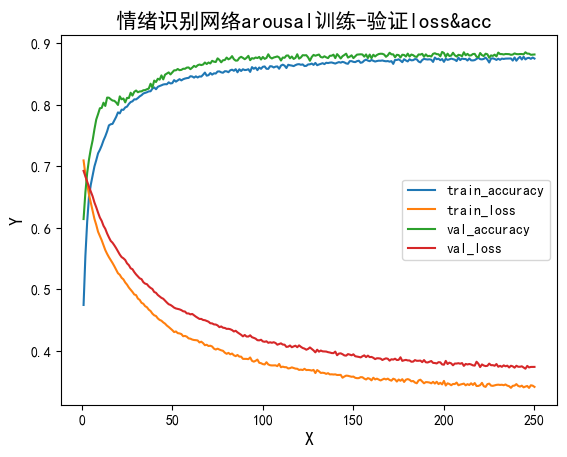

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1002
           1       0.87      0.95      0.90      1421

    accuracy                           0.88      2423
   macro avg       0.89      0.87      0.88      2423
weighted avg       0.88      0.88      0.88      2423

[[ 794  208]
 [  78 1343]]


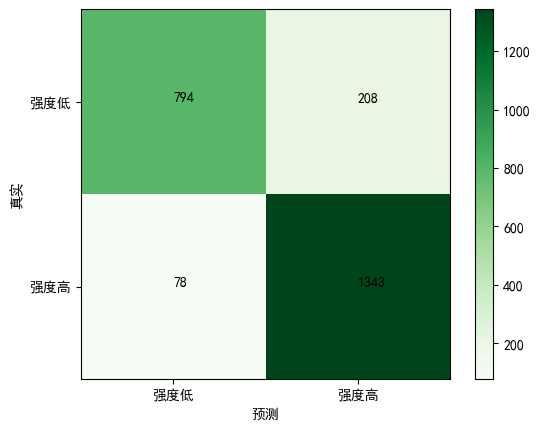

[arousal测试] accuracy:0.8820 precision:0.8820 recall:0.8820 f1:0.8820
=====FOLD_4=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


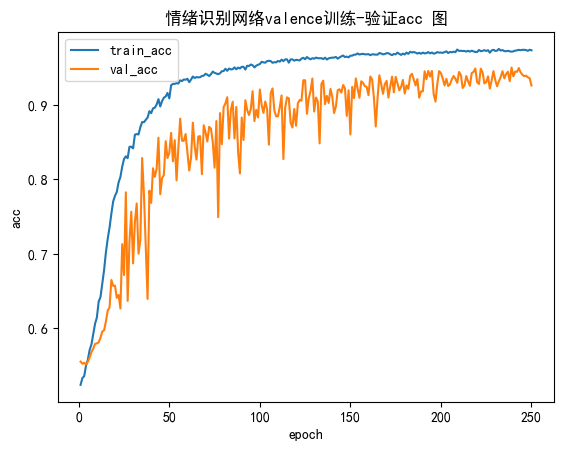

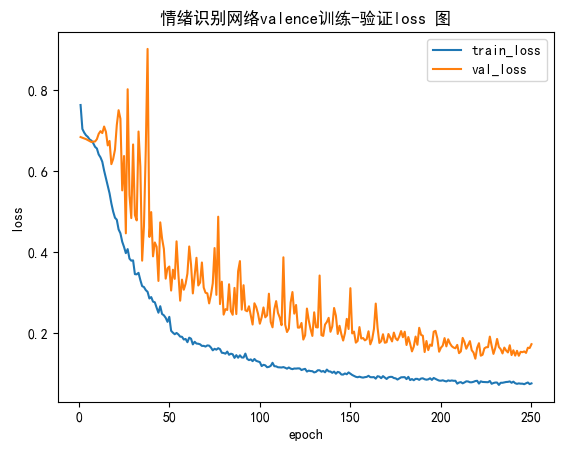

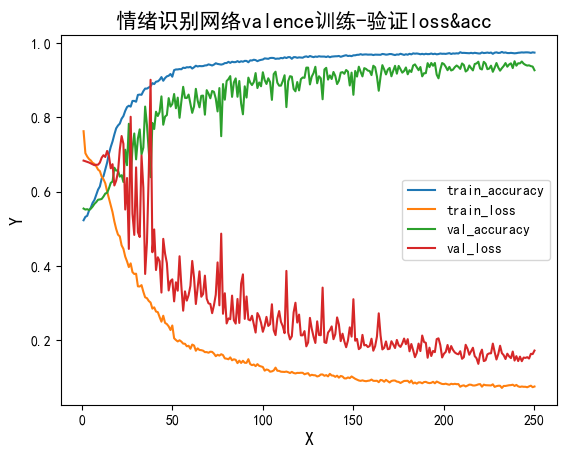

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1320
           1       1.00      0.84      0.91      1103

    accuracy                           0.93      2423
   macro avg       0.94      0.92      0.92      2423
weighted avg       0.93      0.93      0.93      2423

[[1317    3]
 [ 175  928]]


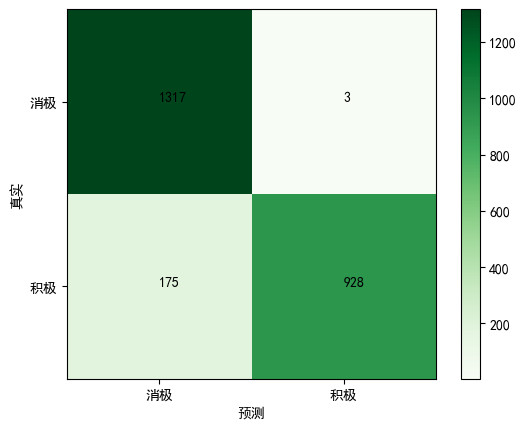

[valence测试] accuracy:0.9265 precision:0.9265 recall:0.9265 f1:0.9265
=====arousal=====


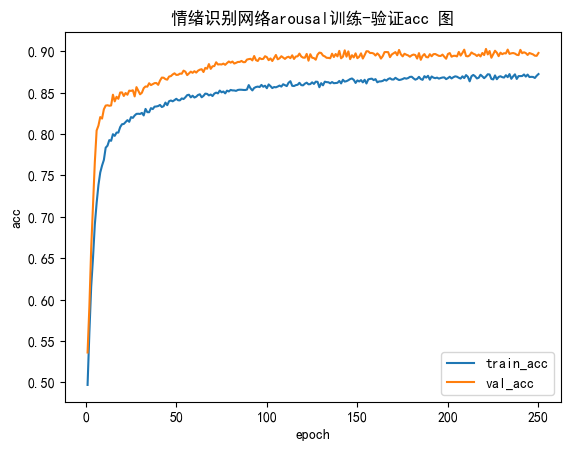

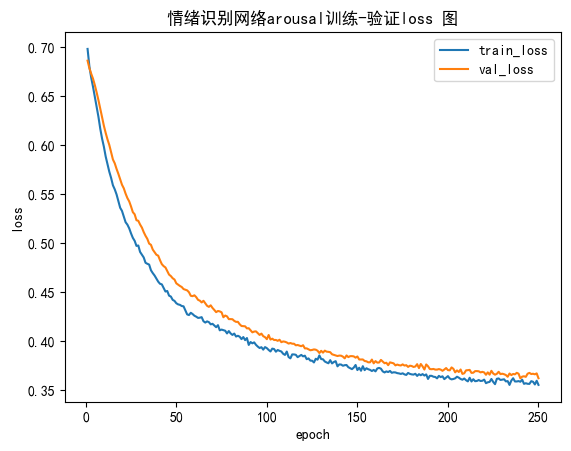

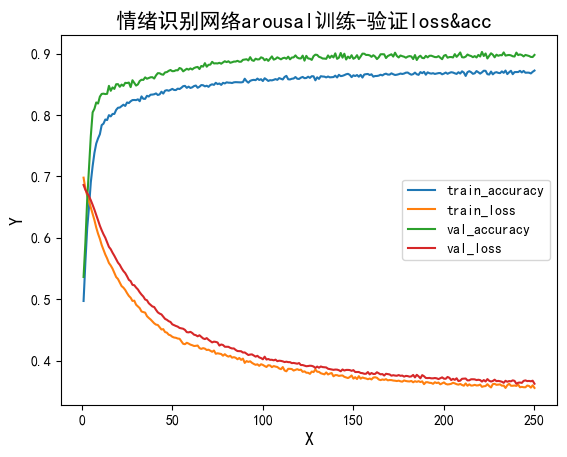

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       996
           1       0.89      0.94      0.92      1427

    accuracy                           0.90      2423
   macro avg       0.90      0.89      0.89      2423
weighted avg       0.90      0.90      0.90      2423

[[ 833  163]
 [  86 1341]]


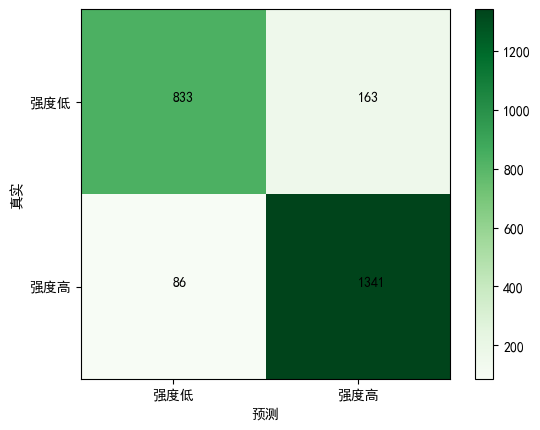

[arousal测试] accuracy:0.8972 precision:0.8972 recall:0.8972 f1:0.8972
=====FOLD_5=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


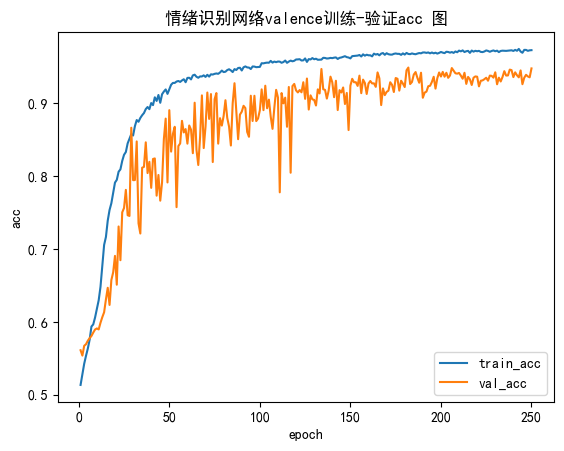

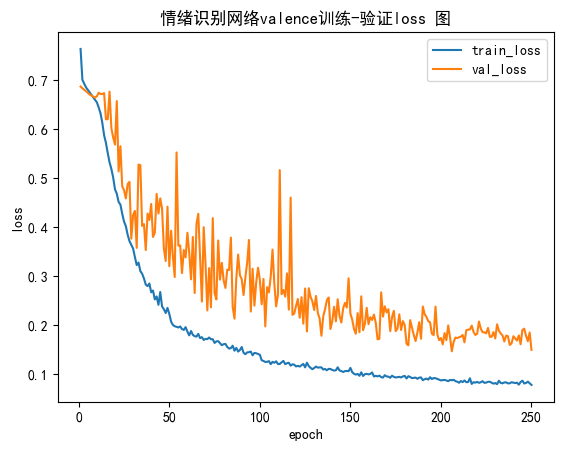

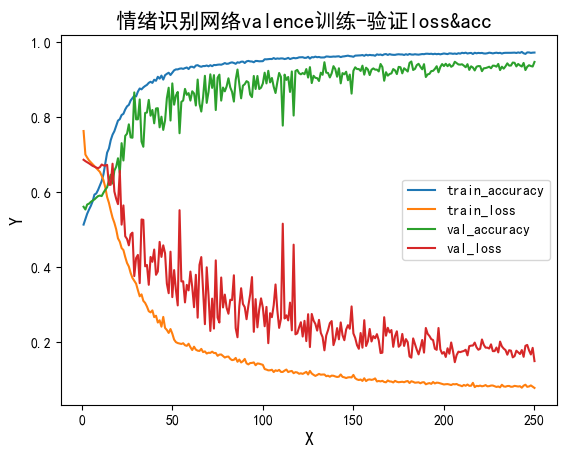

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1320
           1       0.98      0.90      0.94      1103

    accuracy                           0.95      2423
   macro avg       0.95      0.94      0.95      2423
weighted avg       0.95      0.95      0.95      2423

[[1297   23]
 [ 108  995]]


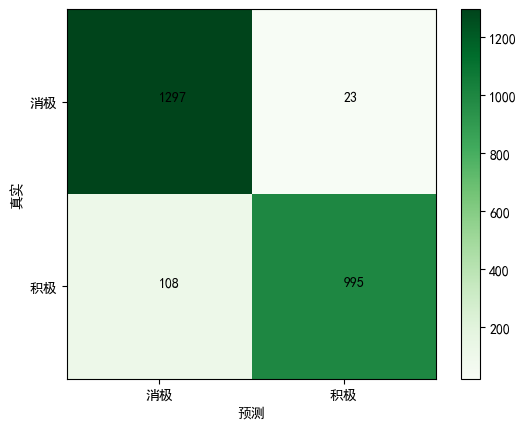

[valence测试] accuracy:0.9459 precision:0.9459 recall:0.9459 f1:0.9459
=====arousal=====


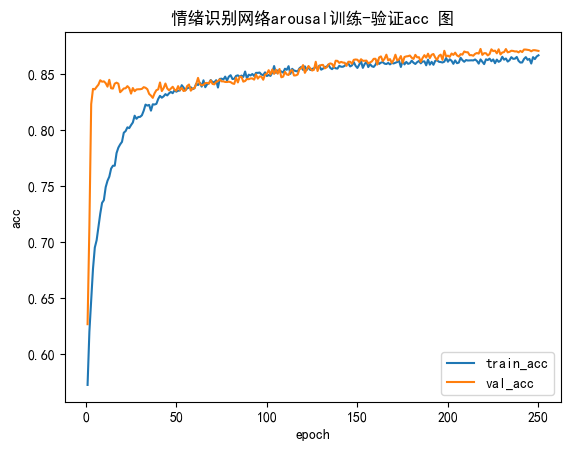

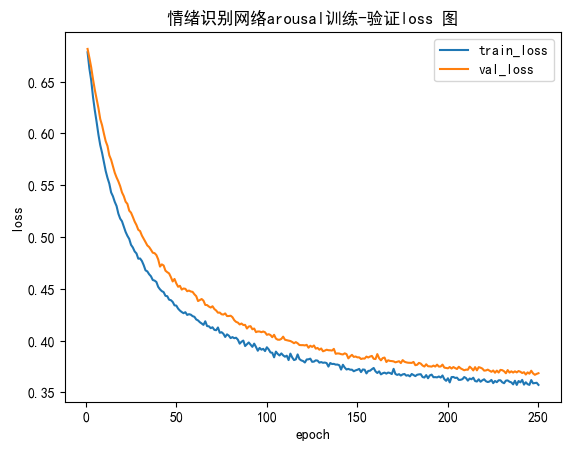

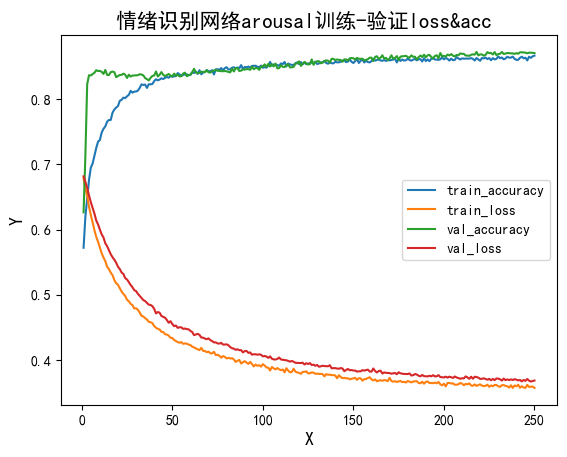

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1006
           1       0.93      0.84      0.88      1417

    accuracy                           0.87      2423
   macro avg       0.87      0.88      0.87      2423
weighted avg       0.88      0.87      0.87      2423

[[ 916   90]
 [ 221 1196]]


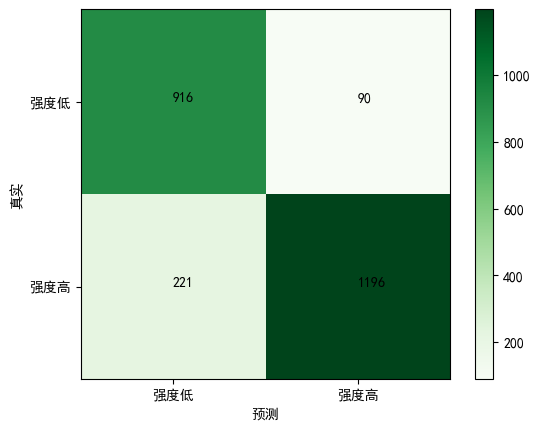

[arousal测试] accuracy:0.8716 precision:0.8716 recall:0.8716 f1:0.8716
=====FOLD_6=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


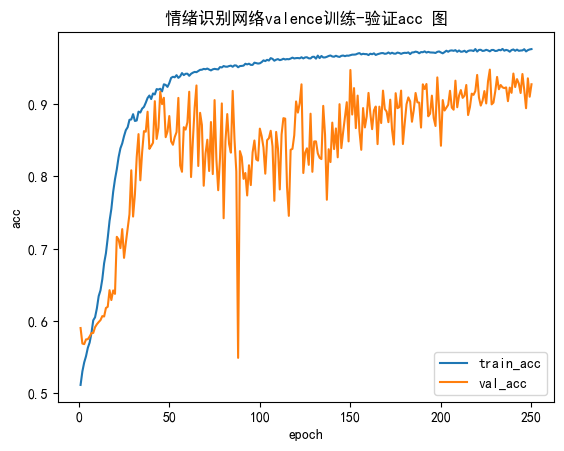

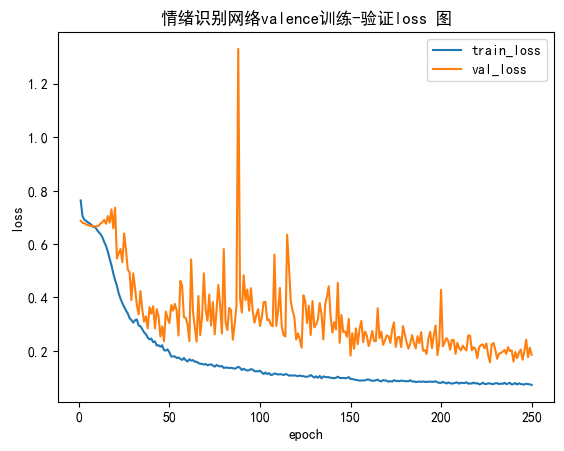

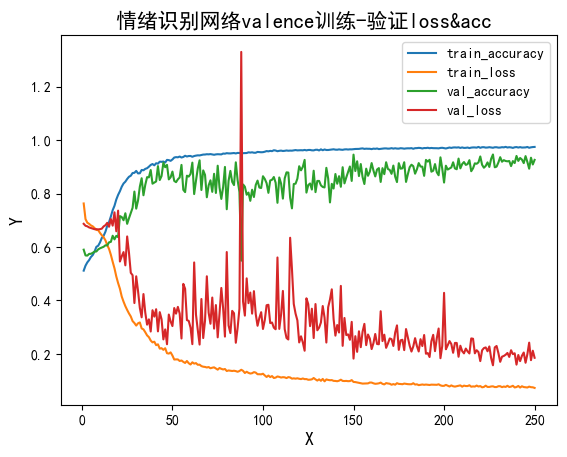

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1320
           1       0.88      0.98      0.92      1103

    accuracy                           0.93      2423
   macro avg       0.93      0.93      0.93      2423
weighted avg       0.93      0.93      0.93      2423

[[1167  153]
 [  26 1077]]


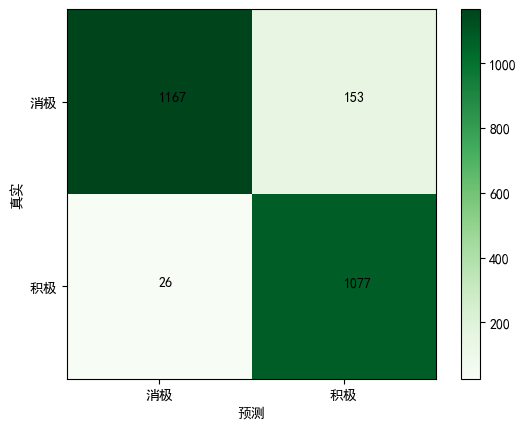

[valence测试] accuracy:0.9261 precision:0.9261 recall:0.9261 f1:0.9261
=====arousal=====


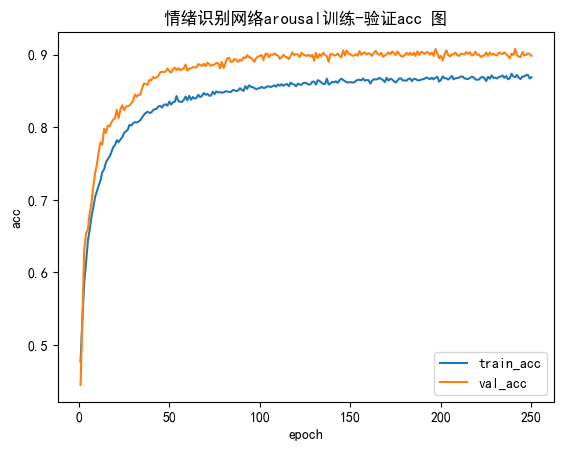

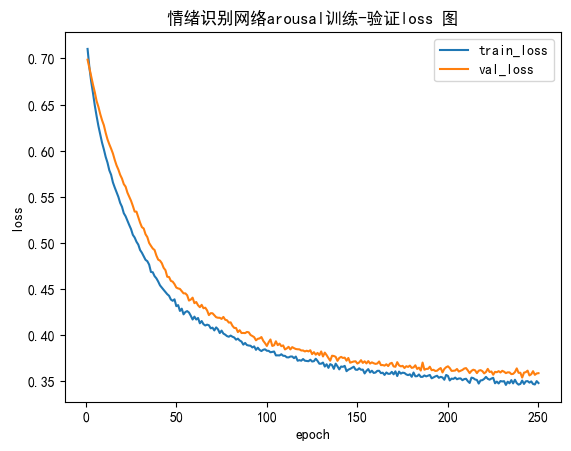

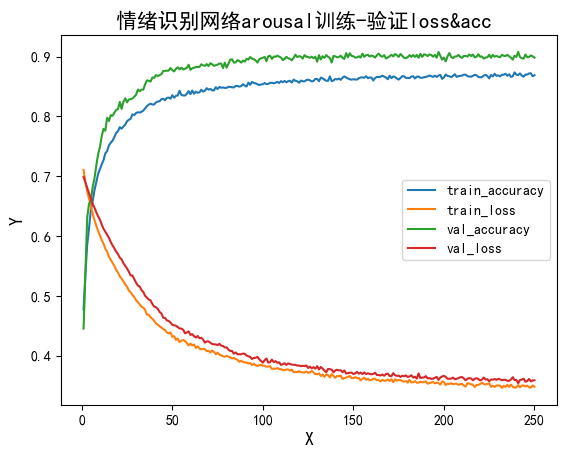

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1005
           1       0.88      0.96      0.92      1418

    accuracy                           0.90      2423
   macro avg       0.90      0.89      0.89      2423
weighted avg       0.90      0.90      0.90      2423

[[ 821  184]
 [  63 1355]]


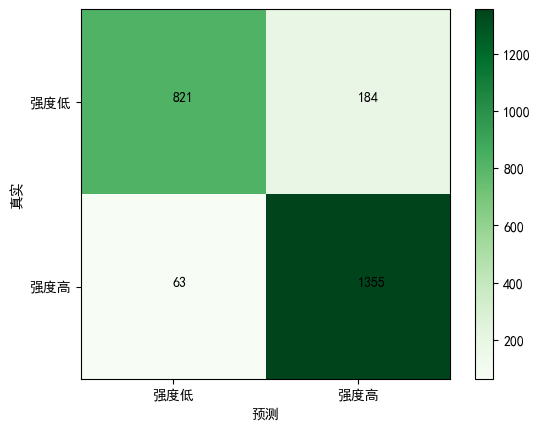

[arousal测试] accuracy:0.8981 precision:0.8981 recall:0.8981 f1:0.8981
=====FOLD_7=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


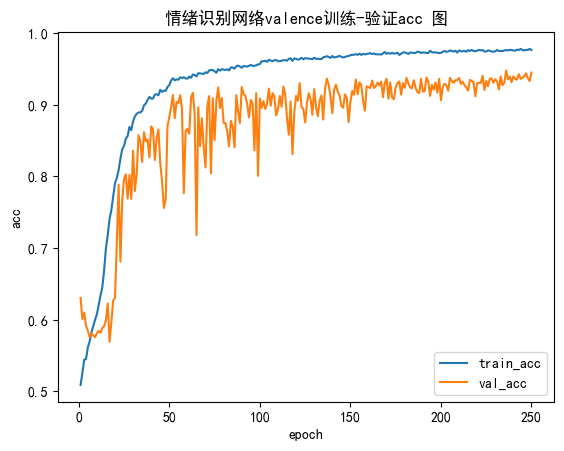

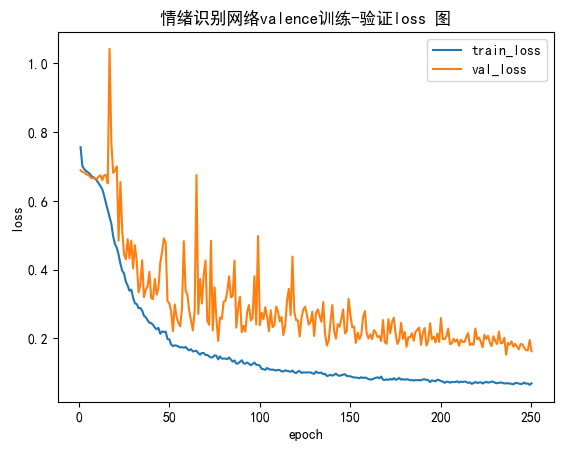

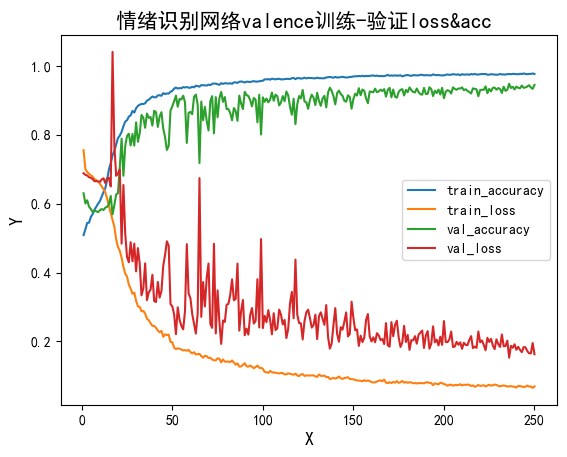

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1319
           1       0.93      0.95      0.94      1103

    accuracy                           0.95      2422
   macro avg       0.94      0.95      0.95      2422
weighted avg       0.95      0.95      0.95      2422

[[1240   79]
 [  53 1050]]


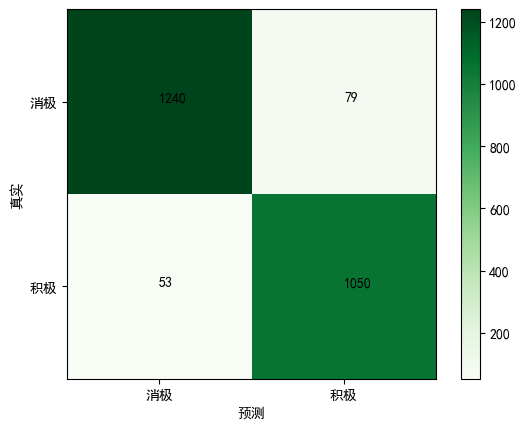

[valence测试] accuracy:0.9455 precision:0.9455 recall:0.9455 f1:0.9455
=====arousal=====


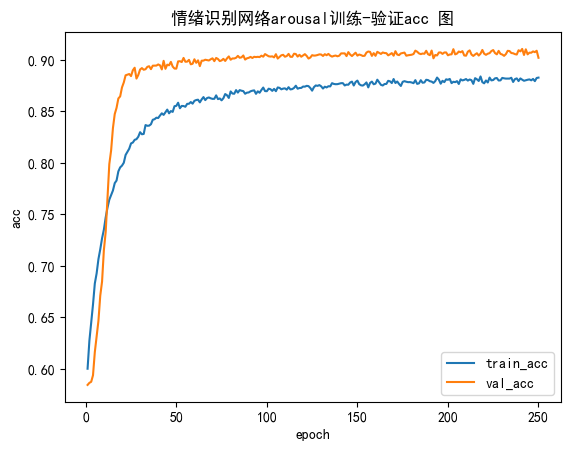

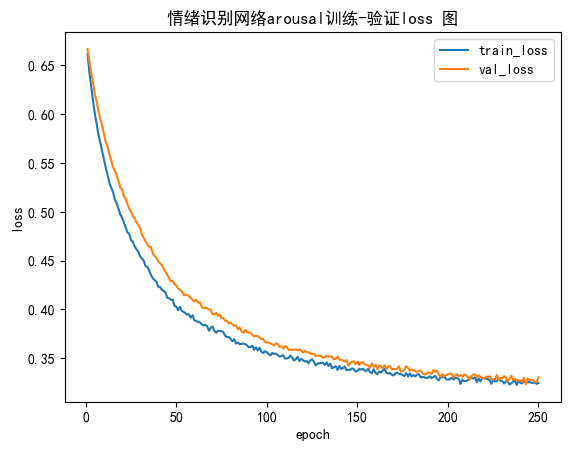

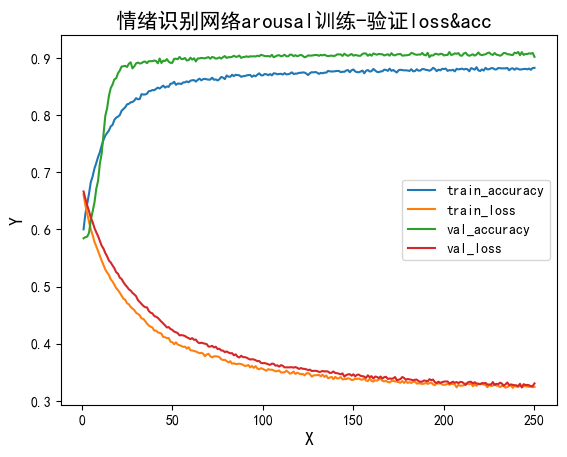

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1003
           1       0.89      0.95      0.92      1420

    accuracy                           0.90      2423
   macro avg       0.91      0.89      0.90      2423
weighted avg       0.90      0.90      0.90      2423

[[ 832  171]
 [  66 1354]]


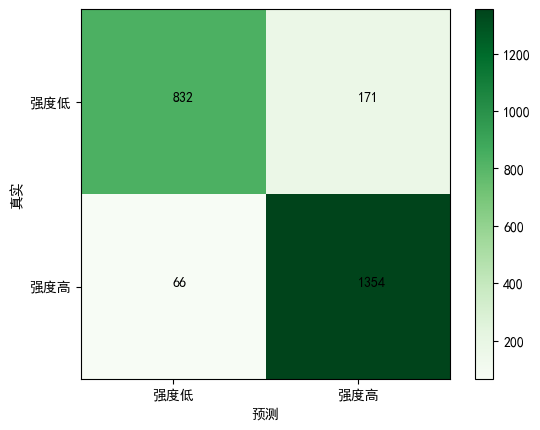

[arousal测试] accuracy:0.9022 precision:0.9022 recall:0.9022 f1:0.9022
保存最优arousal模型model 7
=====FOLD_8=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


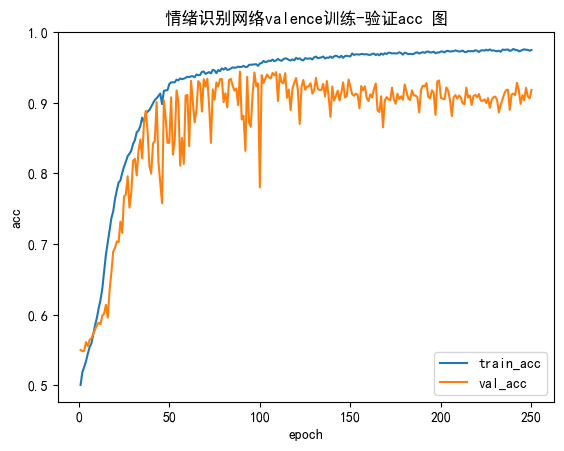

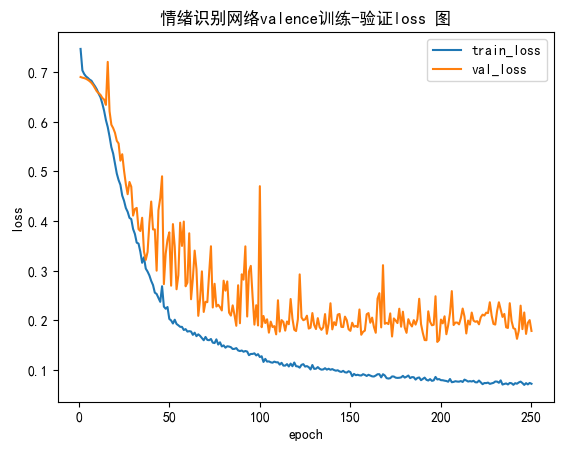

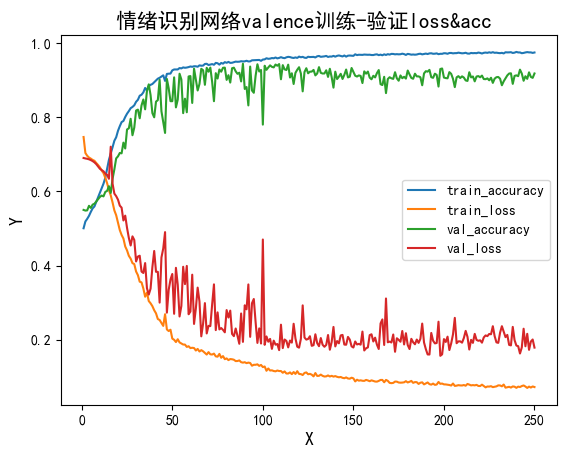

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1319
           1       0.99      0.82      0.90      1103

    accuracy                           0.92      2422
   macro avg       0.93      0.91      0.92      2422
weighted avg       0.93      0.92      0.92      2422

[[1314    5]
 [ 194  909]]


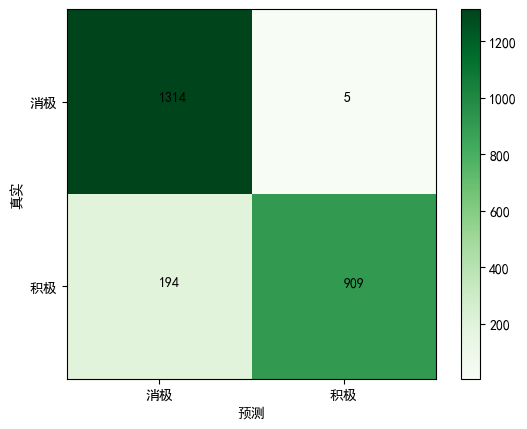

[valence测试] accuracy:0.9178 precision:0.9178 recall:0.9178 f1:0.9178
=====arousal=====


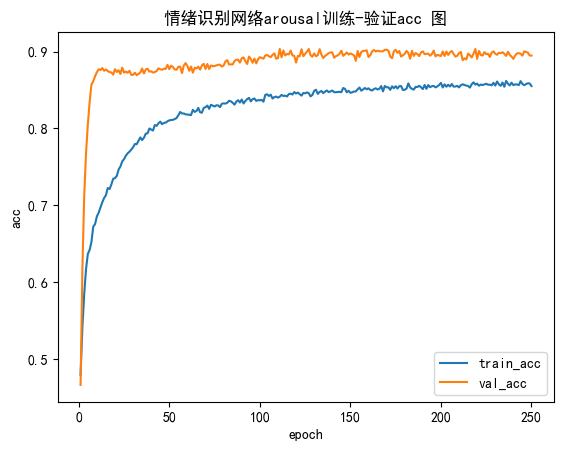

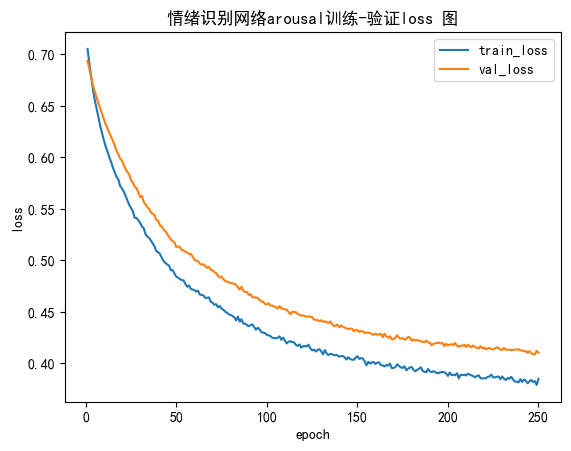

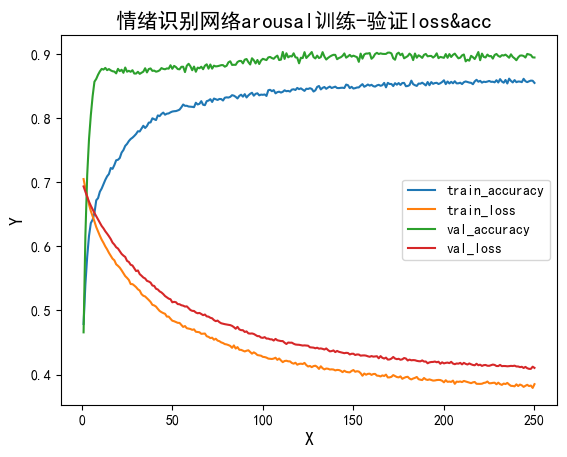

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      1037
           1       0.87      0.96      0.91      1386

    accuracy                           0.89      2423
   macro avg       0.90      0.88      0.89      2423
weighted avg       0.90      0.89      0.89      2423

[[ 833  204]
 [  51 1335]]


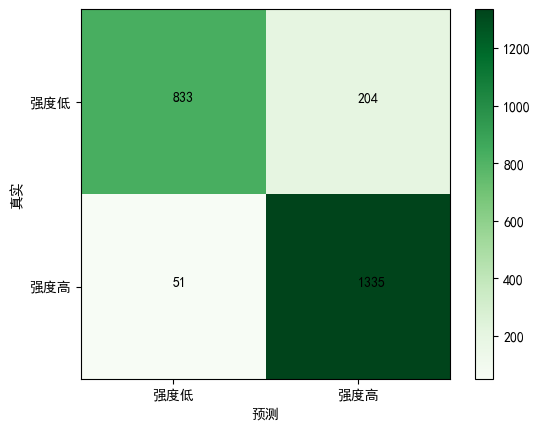

[arousal测试] accuracy:0.8948 precision:0.8948 recall:0.8948 f1:0.8948
=====FOLD_9=====
Let's use 4 GPUs!
=====情绪识别任务训练开始=====
=====valence=====


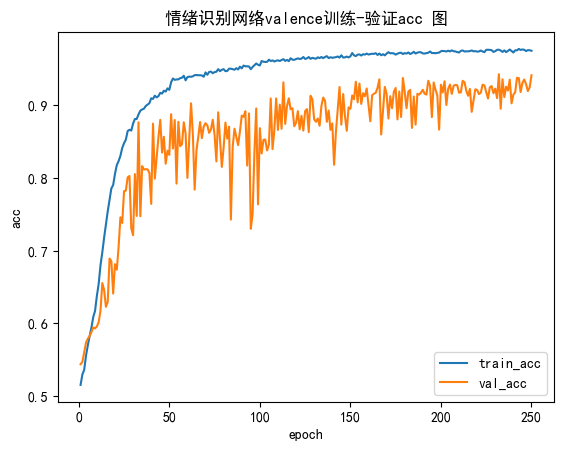

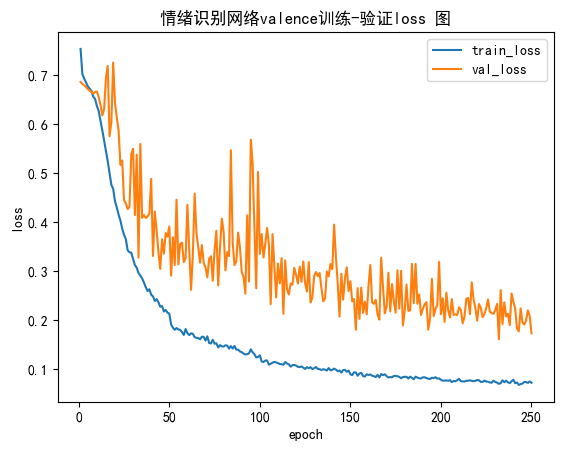

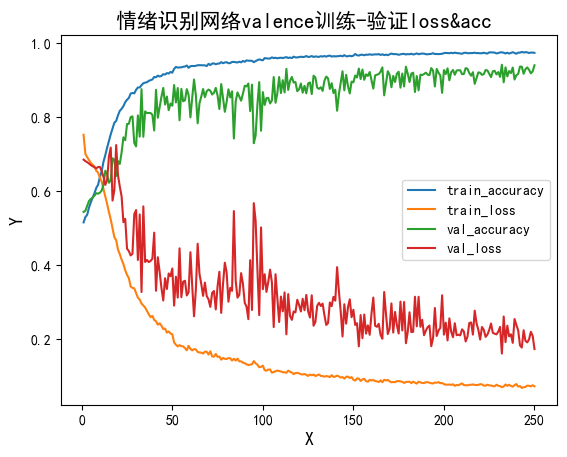

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1319
           1       0.92      0.95      0.94      1103

    accuracy                           0.94      2422
   macro avg       0.94      0.94      0.94      2422
weighted avg       0.94      0.94      0.94      2422

[[1232   87]
 [  57 1046]]


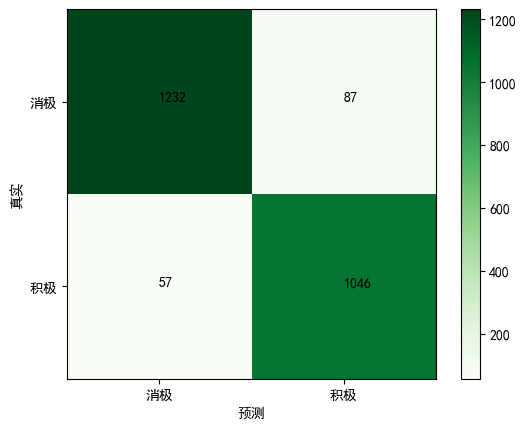

[valence测试] accuracy:0.9405 precision:0.9405 recall:0.9405 f1:0.9405
=====arousal=====


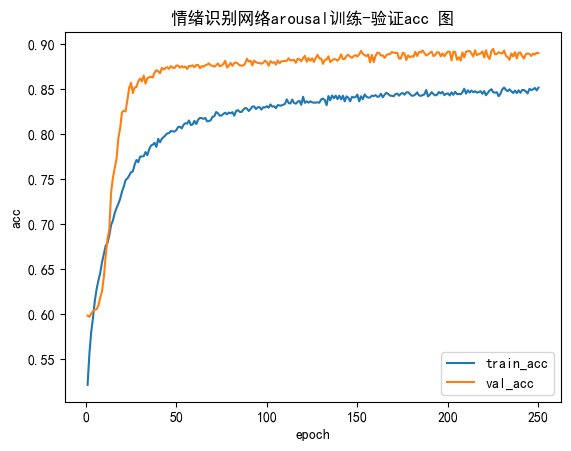

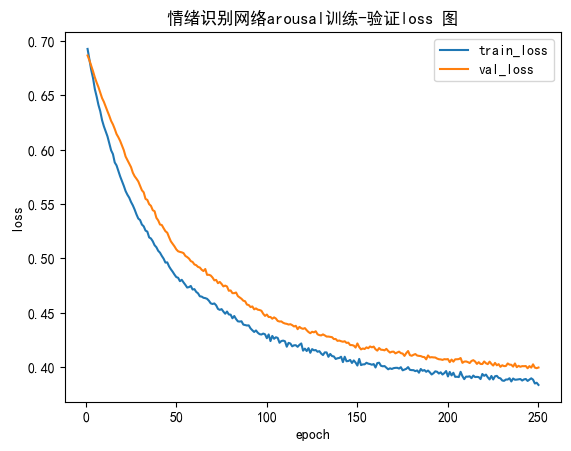

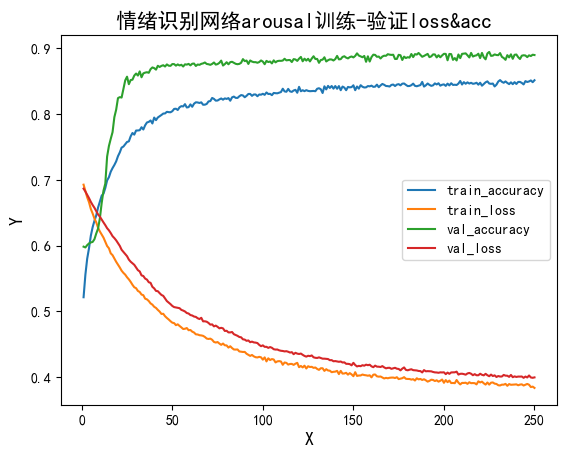

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       969
           1       0.89      0.94      0.91      1453

    accuracy                           0.89      2422
   macro avg       0.89      0.88      0.88      2422
weighted avg       0.89      0.89      0.89      2422

[[ 794  175]
 [  91 1362]]


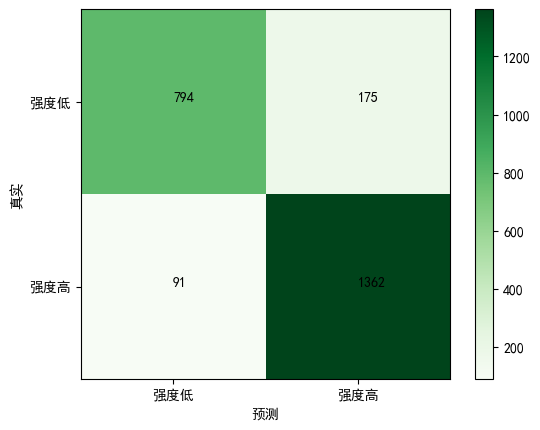

[arousal测试] accuracy:0.8902 precision:0.8902 recall:0.8902 f1:0.8902


In [18]:
#训练


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3]

model1 = []
model2 = []
model3 = []
model4 = []
best_acc1,best_acc2,best_acc3 = 0.0,0.0,0.0


print("=====开始训练网络=====")

for k in range(total_fold):
    train_acc1,train_losses1,test_acc1,test_losses1,train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], [], [], [], [], []
    
    print("=====FOLD_{}=====".format(k))
    train_ECG = np.vstack((load_data_v[train_index_positive[k],1:], load_data_v[train_index_negative[k],1:]))
    
    test_ECG = np.vstack((load_data_v[test_index_positive[k],1:], load_data_v[test_index_negative[k],1:]))
    
    train_label = np.hstack((load_data_v[train_index_positive[k],0], load_data_v[train_index_negative[k],0]))
    
    test_label = np.hstack((load_data_v[test_index_positive[k],0], load_data_v[test_index_negative[k],0]))
    
    train_ECG_a = np.vstack((load_data_a[train_index_0[k],1:], load_data_a[train_index_1[k],1:]))
    
    test_ECG_a = np.vstack((load_data_a[test_index_0[k],1:], load_data_a[test_index_1[k],1:]))
    
    train_label_a = np.hstack((load_data_a[train_index_0[k],0], load_data_a[train_index_1[k],0]))
    
    test_label_a = np.hstack((load_data_a[test_index_0[k],0], load_data_a[test_index_1[k],0]))
    
    if torch.cuda.device_count() > 1:
     print("Let's use", torch.cuda.device_count(), "GPUs!")
    
    #net init
    model = model_CNN().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)#init weight
    model1.append(model)
    
    model= model_Task().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model2.append(model)
    
    model= model_valence().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model3.append(model)
    
    model= model_arousal().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model4.append(model)
    
    criterion = nn.CrossEntropyLoss().to(device)
    #optimizer = optim.Adam(model.parameters(),lr=0.0001)#learning rate too large?
    #optimizer = optim.Adam(model1[k].parameters(),lr=initial_learning_rate)
    optimizer = torch.optim.SGD(model1[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer2 = optim.Adam(model2[k].parameters(),lr=initial_learning_rate)
    optimizer2 = torch.optim.SGD(model2[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer3 = optim.Adam(model3[k].parameters(),lr=initial_learning_rate)
    optimizer3 = torch.optim.SGD(model3[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=50, gamma=0.6)
    
    #optimizer4 = optim.Adam(model4[k].parameters(),lr=initial_learning_rate)
    optimizer4 = torch.optim.SGD(model4[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler4 = optim.lr_scheduler.StepLR(optimizer4, step_size=50, gamma=0.6)
    
    training_length = len(train_ECG)
    testing_length = len(test_ECG)
    
    print("=====情绪识别任务训练开始=====")
    print("=====valence=====")
    for epoch_counter in range(epoch):
        start = time.time()
        
        
        #ssl down stream task
        #model1[k].eval()
        model1[k].train()
        model3[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG,train_label)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model3[k](predictions)

            loss = criterion(predictions,labels.long())
            optimizer.zero_grad()
            optimizer3.zero_grad()
            loss.mean().backward()
            optimizer.step()
            optimizer3.step()


            running_loss += loss.mean().data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[valence-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        
        scheduler.step()
        scheduler3.step()
        
        #print("=====情绪识别训练结束=====")
        #down test
        model1[k].eval()
        model3[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试情绪识别valence任务网络=====")
        test_data = MyData(test_ECG,test_label)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model3[k](predictions)
                test_outputs = predictions.data.cpu().argmax(dim=1)

                loss = criterion(predictions,labels.long())
                
                running_loss += loss.mean().data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[valence-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
            
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"情绪识别网络valence训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_valence)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_valence)
    print("[valence测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
        # 保存模型
    if sklearn_precision > best_acc2:
        print("保存最优情绪识别valence模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/cnn_valence_best_model1")# 只保存模型参数
        torch.save(model3[k].state_dict(),"/home/whh/lt/models/cnn_valence_best_model3")
        best_acc2 = sklearn_precision
    
    print("=====arousal=====")
    train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], []
    
    train_ECG = train_ECG_a
    test_ECG = test_ECG_a
    train_label =train_label_a
    test_label = test_label_a
    
    for epoch_counter in range(epoch):
        start = time.time()
        
        
        #ssl down stream task
        #model1[k].eval()
        model1[k].train()
        model4[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG,train_label)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model4[k](predictions)

            loss = criterion(predictions,labels.long())
            optimizer.zero_grad()
            optimizer3.zero_grad()
            loss.mean().backward()
            optimizer.step()
            optimizer3.step()


            running_loss += loss.mean().data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[arousal-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        
        scheduler.step()
        scheduler3.step()
        
        #print("=====情绪识别训练结束=====")
        #down test
        model1[k].eval()
        model4[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试情绪识别arousal任务网络=====")
        test_data = MyData(test_ECG,test_label)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model4[k](predictions)
                test_outputs = predictions.data.cpu().argmax(dim=1)

                loss = criterion(predictions,labels.long())
                
                running_loss += loss.mean().data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[arousal-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
            
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"情绪识别网络arousal训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_arousal)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_arousal)
    print("[arousal测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
    # 保存模型
    if sklearn_precision > best_acc3:
        print("保存最优arousal模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/cnn_arousal_best_model1")# 只保存模型参数
        torch.save(model4[k].state_dict(),"/home/whh/lt/models/cnn_arousal_best_model3")
        best_acc3 = sklearn_precision
    
            

In [22]:
mid_model = model_CNN()

In [29]:
im = torch.as_tensor(positive_data[0,1:], dtype=torch.float32).view(1,1250)
im.shape
im2 = mid_model(im)

1.9.0+cu111


RuntimeError: Error(s) in loading state_dict for model_arousal:
	Missing key(s) in state_dict: "task_a.0.weight", "task_a.0.bias", "task_a.3.weight", "task_a.3.bias", "task_a.6.weight", "task_a.6.bias". 
	Unexpected key(s) in state_dict: "conv_unit.0.weight", "conv_unit.0.bias", "conv_unit.0.running_mean", "conv_unit.0.running_var", "conv_unit.0.num_batches_tracked", "conv_unit.1.weight", "conv_unit.1.bias", "conv_unit.3.weight", "conv_unit.3.bias", "conv_unit.3.running_mean", "conv_unit.3.running_var", "conv_unit.3.num_batches_tracked", "conv_unit.6.weight", "conv_unit.6.bias", "conv_unit.8.weight", "conv_unit.8.bias", "conv_unit.8.running_mean", "conv_unit.8.running_var", "conv_unit.8.num_batches_tracked", "conv_unit.11.weight", "conv_unit.11.bias". 

In [46]:
model = model_CNN()

im = torch.as_tensor(positive_data[0,1:], dtype=torch.float32).view(1,1250)
im.shape
im2 = model(im)

In [13]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile
print(torch.__version__)

model_pth = '/home/whh/lt/models/valence_best_model1'  # 训练得到的模型参数文件的路径(only params)
mobile_ptl = '/home/whh/lt/models/bi_mobile_model.ptl'  # 模型保存为Android可以调用的文件的路径
#model = mobilenet_v3_large(num_classes=7)  # 实例化模型
model = model_CNN()

pre_weights = torch.load(model_pth, map_location='cpu')  # 读取参数\
model.load_state_dict(pre_weights, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model.to(device)  # 将模型加载到指定设备上
model.eval()  # 将模型设为验证模式

example = im  # 输入样例的格式为一张224*224的3通道图像

# 上面是准备模型，下面就是转换了
#traced_script_module = torch.jit.trace(model, example)
traced_script_module = torch.jit.script(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(mobile_ptl)

model_pth = '/home/whh/lt/models/valence_best_model3'  # 训练得到的模型参数文件的路径(only params)
mobile_ptl = '/home/whh/lt/models/bi_mobile_model_valence.ptl'  # 模型保存为Android可以调用的文件的路径
#model = mobilenet_v3_large(num_classes=7)  # 实例化模型
model = model_valence()

pre_weights = torch.load(model_pth, map_location='cpu')  # 读取参数\
model.load_state_dict(pre_weights, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model.to(device)  # 将模型加载到指定设备上
model.eval()  # 将模型设为验证模式

example = im2  # 输入样例的格式为一张224*224的3通道图像

# 上面是准备模型，下面就是转换了
#traced_script_module = torch.jit.trace(model, example)
traced_script_module = torch.jit.script(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(mobile_ptl)

model_pth = '/home/whh/lt/models/arousal_best_model3'  # 训练得到的模型参数文件的路径(only params)
mobile_ptl = '/home/whh/lt/models/bi_mobile_model_arousal.ptl'  # 模型保存为Android可以调用的文件的路径
#model = mobilenet_v3_large(num_classes=7)  # 实例化模型
model = model_arousal()

pre_weights = torch.load(model_pth, map_location='cpu')  # 读取参数\
model.load_state_dict(pre_weights, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model.to(device)  # 将模型加载到指定设备上
model.eval()  # 将模型设为验证模式

example = im2  # 输入样例的格式为一张224*224的3通道图像

# 上面是准备模型，下面就是转换了
#traced_script_module = torch.jit.trace(model, example)
traced_script_module = torch.jit.script(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(mobile_ptl)




1.9.0+cu111


NameError: name 'im' is not defined

In [51]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

example = im2

traced_script_module = torch.jit.script(model_valence, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter( '/home/whh/lt/models/bi_final_mobile_model_valence.ptl')

In [30]:

from collections import OrderedDict

In [40]:
model_cnn = model_CNN()
pre_weights = torch.load('/home/whh/lt/models/valence_best_model1', map_location='cpu')  # 读取参数\

# 多GPU 模型参数去掉 module
state_dict_new = OrderedDict()
for k, v in pre_weights.items():
    name = k[7:]  # 去掉 `module.`
	# name = k.replace(“module.", "")
    state_dict_new[name] = v

model_cnn.load_state_dict(state_dict_new, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model_cnn.to(device)
model_cnn.eval()

model_CNN(
  (conv_unit): Sequential(
    (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(1, 32, kernel_size=(33,), stride=(1,), padding=(16,))
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool1d(kernel_size=8, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(17,), stride=(1,), padding=(8,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): MaxPool1d(kernel_size=8, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout(p=0.2, inplace=False)
    (14): MaxPool1d(kernel_size=308, stride=308, padding=0, dilation=1, ceil_

In [41]:
model_valence = model_valence()

pre_weights = torch.load('/home/whh/lt/models/valence_best_model3', map_location='cpu')  # 读取参数\

# 多GPU 模型参数去掉 module
state_dict_new = OrderedDict()
for k, v in pre_weights.items():
    name = k[7:]  # 去掉 `module.`
	# name = k.replace(“module.", "")
    state_dict_new[name] = v

model_valence.load_state_dict(state_dict_new, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种

model_valence.to(device)
model_valence.eval()

model_valence(
  (task_v): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [42]:
model_arousal = model_arousal()
pre_weights = torch.load('/home/whh/lt/models/arousal_best_model3', map_location='cpu')  # 读取参数\

# 多GPU 模型参数去掉 module
state_dict_new = OrderedDict()
for k, v in pre_weights.items():
    name = k[7:]  # 去掉 `module.`
	# name = k.replace(“module.", "")
    state_dict_new[name] = v

model_arousal.load_state_dict(state_dict_new, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种

model_arousal.to(device)
model_arousal.eval()

model_arousal(
  (task_a): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [85]:
# 加载原始数据neutral1
df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
# 拆解heartbeat_signals
train_signals = np.array(df_train['ecg'],dtype=np.float32)
#信号过滤
train_signals = medfilt_ecg(train_signals,window_size)

In [86]:

mid_num = len(train_signals[0:(len(train_signals)-1250)])//125
for i in range(mid_num):
    signal = torch.as_tensor(train_signals[i*125:i*125+1250], dtype=torch.float32).view(1,1250)
    
    
    mid = model_cnn(signal)
    out1 = torch.argmax(model_valence(mid))
    out2 = torch.argmax(model_arousal(mid))
    if(out1==1 and out2==0):
        print("====={}=====",i)
        print(out1)
        print(out2)



====={}===== 11
tensor(1)
tensor(0)
====={}===== 12
tensor(1)
tensor(0)
====={}===== 13
tensor(1)
tensor(0)
====={}===== 14
tensor(1)
tensor(0)
====={}===== 15
tensor(1)
tensor(0)
====={}===== 16
tensor(1)
tensor(0)
====={}===== 17
tensor(1)
tensor(0)
====={}===== 18
tensor(1)
tensor(0)
====={}===== 19
tensor(1)
tensor(0)
====={}===== 20
tensor(1)
tensor(0)
====={}===== 29
tensor(1)
tensor(0)
====={}===== 30
tensor(1)
tensor(0)
====={}===== 31
tensor(1)
tensor(0)
====={}===== 32
tensor(1)
tensor(0)
====={}===== 33
tensor(1)
tensor(0)
====={}===== 34
tensor(1)
tensor(0)
====={}===== 36
tensor(1)
tensor(0)
====={}===== 45
tensor(1)
tensor(0)
====={}===== 48
tensor(1)
tensor(0)
====={}===== 49
tensor(1)
tensor(0)
====={}===== 50
tensor(1)
tensor(0)
====={}===== 51
tensor(1)
tensor(0)
====={}===== 52
tensor(1)
tensor(0)
====={}===== 53
tensor(1)
tensor(0)
====={}===== 54
tensor(1)
tensor(0)
====={}===== 56
tensor(1)
tensor(0)
====={}===== 79
tensor(1)
tensor(0)
====={}===== 80
tensor(1)
te

In [43]:
print(negative_data.shape)

(13197, 1251)


In [118]:
aba = [-390.18134,-250.08083,355.13745,1093.7435,1126.9191,333.96118,-250.48608,-198.4105,-101.91079,-128.19073,-96.38683,-93.56311,-108.626595,-84.06771,-85.659775,-70.6766,-22.814592,-7.194055,10.111572,5.981267,3.4464464,2.9366384,5.8874416,4.9120617,3.9554667,8.570641,12.601982,17.625507,24.853828,26.816168,28.408533,35.270897,40.200317,36.668728,24.625927,8.199696,-3.4146786,-8.947861,-10.901518,-7.5220275,-1.476018,3.5986524,9.090963,12.655855,11.863052,11.083918,12.115133,11.801092,11.964289,11.6460705,10.748606,13.42054,13.180109,6.255812,5.4087434,8.399197,6.548894,3.7070951,2.7749157,1.2297115,-0.6234045,-1.3390889,2.0512185,6.8879447,7.340204,13.245348,30.481108,42.24118,45.15515,48.24375,40.665543,24.561737,18.391962,16.921476,-0.15584707,-22.38711,-53.334457,-63.825577,-79.50143,-65.595276,-74.20798,-82.838104,-80.76197,-193.4365,-367.7693,-308.84515,212.34668,966.08,1131.8264,427.044,-208.1466,-216.99945,-109.7046,-120.74745,-90.1593,-83.12012,-96.928085,-75.83122,-78.15049,-68.80112,-26.794325,-12.506845,11.275879,8.086176,9.053799,11.873167,10.571136,10.57443,12.030804,10.170952,14.827425,20.134304,18.175074,22.24155,28.838018,28.685785,30.769117,32.7094,20.790257,3.024149,-7.016915,-9.011169,-4.339496,0.20586729,-0.18863153,1.272162,6.147355,8.026684,10.841829,14.627981,12.335558,11.465242,11.468067,7.8863363,7.063607,7.64694,8.157791,11.495707,11.998077,8.429899,7.0413094,6.222295,2.0464315,-2.003696,-1.3856025,2.5653906,4.5925837,6.503009,8.921503,8.174637,17.879772,41.09573,51.058834,45.245266,42.586384,34.526875,17.93603,15.373552,11.806753,-7.0159297,-42.961823,-66.3976,-78.1359,-83.20002,-80.65709,-92.618675,-88.37906,-127.447914,-306.6206,-417.07675,-90.72948,668.2006,1217.826,880.66394,46.14377,-299.69604,-143.48463,-76.02537,-111.94505,-91.5886,-92.69686,-97.75674,-82.459366,-87.88328,-58.7007,-17.99545,-3.106626,5.5299177,7.2004843,1.6726315,-1.2381539,3.3358855,5.4537115,5.8986588,6.303913,5.4321995,10.635563,14.593454,11.769203,14.240725,26.164135,36.65751,36.09868,21.011473,3.6111717,-5.9051547,-9.276293,-6.6270814,0.290905,5.3154755,9.108955,12.775549,12.563795,12.154285,9.756748,7.0833507,10.215895,14.467176,12.6952,5.575094,5.547038,11.950861,8.4047,2.430515,5.4060316,8.624274,6.052867,1.8588345,1.9792597,4.1747518,0.9951174,-4.0770574,-4.747502,-0.2768693,10.257303,12.601494,6.3051653,14.863974,34.649445,41.851612,44.374367,46.633038,34.123726,15.738016,14.109865,12.135139,-4.2435546,-38.25453,-60.13826,-73.01713,-79.03706,-79.71109,-96.468895,-92.48109,-144.10364,-309.81088,-388.60834,-93.6797,621.8981,1176.1648,837.16,43.500698,-222.11353,-91.06283,-96.79131,-123.41899,-88.87888,-103.49499,-98.337395,-78.10204,-89.349304,-60.10025,-23.680344,-7.024423,2.8928614,1.7397654,4.372284,1.2767234,0.98596954,6.4538646,6.343418,8.317902,17.220182,21.678728,24.957727,29.955242,33.96466,39.446033,41.063297,29.279167,14.943626,4.2103796,-9.119528,-16.367346,-8.883158,0.9042709,-0.21500254,-2.7196765,5.369036,12.1228485,7.763319,5.517103,10.23197,10.013374,7.193928,9.705152,11.005421,8.010715,9.8347435,11.044589,3.6998422,1.1382205,2.57805,0.91478515,4.637353,8.5546875,1.3882606,-3.5902944,2.7757056,2.5356317,2.2691455,17.949026,35.12633,42.93727,48.200466,45.682316,33.253563,21.415743,19.406626,9.566081,-8.926931,-25.903557,-50.006134,-29.792274,-37.92181,-55.929436,-19.577517,-46.22619,-102.43213,-213.4138,-368.13773,43.91429,849.67365,783.5787,23.912857,-209.66655,-58.130302,-59.391113,-54.049393,-36.630444,-64.331505,-36.528637,-34.54375,-52.628166,-30.003914,-18.59571,-0.9277291,7.369898,5.334743,2.5934174,-0.092213154,-0.40971327,2.1621053,5.1298833,10.570259,17.295967,18.710743,19.367458,26.438166,33.75187,38.631207,43.10908,41.17343,27.921797,10.793409,-4.875973,-12.561506,-12.295246,-12.905251,-10.394703,-0.05599165,5.195635,7.4302955,13.484028,16.983488,17.034037,11.345959,0.864264,-0.47186327,5.4683485,6.948656,8.308968,10.261915,7.9475117,7.134615,10.148784,10.928171,7.9427457,4.1888347,3.5636613,2.1582682,0.63184524,2.0795877,0.20532393,-2.1502004,4.285497,4.257992,-1.3020196,13.761009,36.20624,42.444687,43.65541,44.09637,37.05415,24.799088,17.51032,-6.450626,-11.558836,-61.30529,-69.54366,-45.83687,-94.943504,-72.34029,-59.511284,-123.25134,-101.529106,-318.51105,-469.5467,416.93094,1324.0657,790.0956,-83.427536,-173.15088,-86.540825,-104.599754,-64.51807,-84.193596,-85.96495,-50.76422,-77.688484,-66.90341,-47.324253,-20.926086,6.293315,9.937393,-3.373496,-4.683065,1.2801857,-0.6237297,0.8938379,4.9909143,4.2514973,6.5818458,12.2288685,17.250916,21.701946,21.759184,18.570341,24.25202,30.959509,28.678633,16.797445,1.674995,-6.513123,-7.2803597,-5.017551,1.6777222,7.628418,7.8661413,7.0774555,6.6556606,6.6016006,7.3073673,8.624498,12.848282,15.624317,10.528609,5.2263002,9.197292,12.4716625,9.15623,7.635146,5.7778387,5.175922,8.256237,9.905676,5.7877207,-0.98337793,-2.5860572,-0.13544416,-2.696035,-1.6587787,7.209346,7.653031,6.7192283,22.625849,38.19235,42.492825,48.137035,45.765392,28.407913,7.905319,-0.5521555,-30.667625,-71.90392,-73.18748,-96.496735,-85.48393,-91.417206,-129.97568,-93.96483,-117.15378,-313.63406,-304.6356,286.5603,1069.0653,1124.5364,346.87234,-245.40103,-199.9648,-93.32,-129.70943,-108.942474,-102.13993,-111.202415,-77.19461,-84.38166,-75.82417,-28.722591,-12.575521,8.369435,3.1819725,0.6671634,0.6083622,-0.12074566,-0.68120384,1.4523196,3.7962017,5.1573086,10.028427,18.758883,22.327486,22.408651,28.662493,35.65022,36.043743,35.83113,32.475582,15.263477,-4.2931914,-10.843304,-7.6139235,-5.9395366,-2.3801703,2.5625772,3.4388976,2.869348,5.125904,7.545225,7.2429686,6.1483784,4.6492877,4.624193,5.7009044,4.2044935,4.5347567,8.00418,7.929149,4.6962337,3.7968302,7.0308886,9.149682,4.843525,3.0446997,0.65411377,-5.959006,0.021232605,7.445388,1.0127091,9.953484,35.429676,42.84396,43.158714,49.06982,44.74488,33.2314,20.129969,-2.1833844,-24.42911,-56.138435,-70.57837,-86.40265,-74.550835,-85.95381,-91.43488,-91.815575,-203.69537,-360.64984,-289.33713,232.2432,983.3543,1125.4513,398.36102,-219.05762,-205.325,-102.714195,-117.96614,-88.1212,-91.53707,-106.87629,-78.10127,-84.30606,-80.69389,-32.60811,-14.704618,5.3506613,3.9745445,4.857815,5.67387,9.991587,6.387127,-0.12922812,4.0811663,10.057291,11.729643,21.030853,31.892733,33.6398,36.557487,40.509354,42.798073,42.48465,28.345938,2.7085378,-13.731415,-19.264982,-21.731522,-12.004414,2.7244256,4.3457108,1.2931097,2.8001926,2.466015,3.8422596,8.015978,6.44164,4.0626173,7.605812,7.1866426,5.142292,8.64452,8.887186,7.964958,14.287243,15.142878,7.9769087,6.5314226,8.649908,5.6462765,0.8965521,-1.2309537,-0.46273947,-0.88866425,-2.9965634,2.153051,10.542204,11.031952,14.087139,28.031334,37.08378,43.013718,50.367382,47.05167,34.85938,19.533142,0.85042,-28.84747,-65.5614,-74.55458,-80.5278,-80.7295,-102.54255,-104.30827,-116.55066,-264.53455,-414.34286,-224.00813,443.80197,1144.9839,1056.0312,236.1784,-256.74783,-151.87204,-76.004486,-125.93894,-101.30816,-95.65493,-104.02409,-82.34444,-89.84387,-70.171715,-22.775505,-10.896608,4.3834906,4.430498,2.946066,1.5231724,3.3323317,4.496583,0.93771935,2.4611845,11.216305,15.236744,15.040821,18.563639,19.665558,19.098223,25.31775,33.277622,28.38918,10.040745,-3.1148338,-4.3942904,-3.51545,-2.08465,1.3934879,7.623802,14.728996,16.74853,12.093063,8.815641,12.085783,12.165979,7.8397846,8.009467,8.293802,5.908139,5.6639175,5.1005588,0.6938033,0.18170929,5.0335083,6.7429237,9.494431,10.2181425,8.210003,7.9985256,3.176731,-0.34776163,3.6872787,3.0461264,3.154602,10.999741,12.933538,5.2380104,6.5314703,26.90306,41.715202,44.793,57.307423,57.73918,36.606464,5.4673076,-21.755102,-49.39811,-59.15377,-67.36431,-75.52684,-79.35538,-99.80127,-100.866585,-144.62012,-305.11243,-412.57974,-144.60855,595.8745,1200.644,890.3448,83.99108,-225.27637,-115.025986,-91.65752,-107.84703,-102.74567,-123.898476,-98.80403,-73.009865,-93.721664,-67.14235,-28.775925,-9.480917,2.928349,-2.0965977,-1.6882095,8.155578,8.47575,-1.2092333,-0.4141159,7.4595566,14.49674,13.871845,10.530233,18.86444,31.823147,36.512253,38.852177,40.25814,29.003525,7.7757597,-6.7390895,-7.5446744,-7.1066194,-6.690348,3.0889206,11.441189,3.3581667,-8.515606,2.6989856,16.553679,4.634941,-3.424769,9.700708,13.948927,2.1825447,-1.4292421,2.4877253,5.4173703,11.840353,12.234604,0.19184685,-2.1620321,11.173254,7.2173257,-3.5461292,6.774626,11.454361,-0.058753014,1.1312642,6.7400017,11.730936,30.466793,39.00574,33.949844,38.252197,40.21652,25.41004,18.133146,8.765144,-7.7822967,-33.100002,-51.161995,-79.196075,-78.54689,-70.28755,-78.53908,-83.97429,-159.22002,-306.97333,-356.9433,-48.682137,672.78845,1145.0568,718.1288,-9.166504,-208.06924,-110.078705,-101.061554,-102.46904,-101.93722,-111.37549,-85.64982,-76.05495,-79.85233,-51.090523,-33.153477,-7.7274833,16.628954,19.944216,-0.35169315,-10.116833,0.022018433,1.8382659,6.3314104,15.126127,16.94293,28.869106,34.248943,26.61921,38.907215,49.55751,44.266617,43.27943,24.239822,-5.5099998,-13.811659,-13.031631,-6.8957305,-2.897931,-19.021019,-12.900864,14.068932,10.120895,-5.187675,2.294322,5.618968,5.5888934,9.529236,1.5089889,-1.3739071,4.2864723,8.900656,11.575897,14.520155,13.023197,10.9581585,11.89403,9.704317,9.493292,16.116995,9.129574,-0.33189678,7.5610123,3.2554688,-12.2741585,-4.1445765,10.136412,6.93104,6.8639603,25.771488,47.257694,55.650955,42.48195,26.403692,22.98853,12.553772,-2.3911748,-23.32153,-64.87289,-88.24491,-82.06385,-64.077614,-83.39202,-88.221855,-118.25543,-278.42575,-412.84583,-213.35403,443.8606,1136.8516,1040.3038,238.4232,-234.0922,-160.80449,-100.93725,-114.02094,-90.112206,-109.80252,-107.24972,-78.90076,-92.31267,-71.217766,-29.902996,-14.57633,11.288259,2.3775973,-3.7861166,3.4951477,-8.245504,-7.9097238,13.17778,13.045509,11.443428,24.786802,32.812683,32.624065,34.59868,43.595203,49.228016,36.898712,22.726027,17.605738,-6.20066,-25.29188,-17.53981,-15.082367,-8.1292515,4.611631,-1.0748577,4.5693536,19.191025,8.61392,0.3079071,8.11438,12.123524,13.690327,6.7619915,-4.14706,0.8836498,7.3937235,7.1432304,13.820833,13.812939,15.267904,29.316431,20.707773,5.5980353,10.592671,15.428013,11.633398,12.975996,17.722786,15.609331,4.991337,-5.48204,-6.895881,-2.9664106,-1.6048245,-3.1359863,-3.3045769,-1.5903964,-5.985312,-7.5476975,-2.741115,-2.1991515,-0.22159147,1.8001733,-0.2447362,17.171432,42.05606,45.85818,46.80033,50.0314,37.122787,22.48958,19.644865,10.952169,-5.9631314,-29.538105,-57.19058,-63.533638,-68.880684,-66.38342,-83.60605,-87.36704,-98.37253,-234.41663,-370.29587,-198.24362,395.2527,1043.2994,996.6007,234.8102,-261.07816,-168.11671,-81.84976,-123.82937,-91.02318,-82.47318,-101.13124,-78.264404,-75.65933,-62.516808,-22.02147,-5.253095,9.454178,7.7275677,7.156233,6.882908,5.4279385,9.261753,12.389154,14.4235,20.965034,28.190104,33.225533,39.982784,45.5118,46.372185,45.2413,41.221237,28.655584,5.016227,-16.252054,-22.458736,-19.713833,-17.001593,-11.843922,-3.2698698,4.2736216,9.941818,14.596144,13.452402,11.156467,15.280615,17.625336,15.943335,16.479092,11.395528,1.1017175,-0.3833933,3.2820501,3.110383,1.7819304,-2.2524743,-4.4497705,2.5850859,6.050215,2.625228,12.30258,34.495136,46.412766,50.225193,54.739807,46.024876,24.804733,18.592459,19.536789,2.5889215,-27.152317,-60.02118,-69.908066,-82.34301,-72.387024,-86.15715,-91.36091,-102.90218,-234.93137,-367.8912,-204.58461,385.9947,1056.2388,1041.4597,292.09253,-247.15358,-219.3386,-121.3287,-111.46026,-90.25699,-100.37306,-99.66172,-82.19835,-85.422325,-38.830334,14.152458,22.41853,49.477104,39.221996,22.973314,20.783583,9.572804,-6.210962,-33.472576,-73.38732,-94.856186,-90.82867,-84.30463,-105.94459,-108.0597,-141.99147,-303.3434,-417.17664,-133.6719,622.59753,1250.6554,976.076,129.61702,-258.82687,-137.15044,-85.66124,-119.28531,-106.308266,-117.97057,-112.41049,-93.184944,-108.05454,-75.27486,-22.743538,-6.049272,7.5901003,8.934225,2.243197,-7.437677,-7.3876834,0.5640359,4.1165414,6.599097,13.167522,13.624773,16.063122,32.80265,48.24244,55.17097,50.065456,34.987118,20.484673,5.526599,-6.576102,-11.665028,-15.5703125,-10.289597,-3.6817698,-7.892616,-0.19842005,18.684282,17.168627,11.686203,12.386381,7.3892365,7.626436,9.736825,5.1839237,5.785896,4.4869204,3.065507,8.74955,5.876443,2.1818104,6.330594,7.7724533,10.953128,15.02132,12.809832,12.640406,13.815245,8.700724,5.9457035,4.748667,-1.7810869,-3.2432666,-0.073214054,-0.59403086,2.310656,5.0932612,5.0197277,13.251324,29.572285,39.10719,41.48255,44.456635,38.53347,23.561634,17.305002,19.548847,4.468736,-20.23219,-57.791527,-73.28414,-92.50414,-85.99864,-90.55224,-104.56485,-97.65977,-183.33455,-367.77383,-356.9926,143.32437,946.6514,1230.2491,588.06116,-132.29533,-219.79567,-100.85797,-123.074646,-115.01794,-91.27897,-105.603485,-92.07271,-87.45873,-85.15465,-43.477135,-24.952188,-6.396463,-4.943235,-4.0840125,-5.811788,-6.795177,-5.148124,-2.174323,3.0547104,9.855995,15.792984,22.167152,31.458391,40.762054,48.9265,58.358284,58.360466,41.143486,20.746178,7.2728615,-4.5056453,-15.439035,-16.782679,-7.8990607,-3.6188593,-3.3109484,1.5619521,7.0747075,9.9973755,11.264189,12.595156,11.629408,9.329943,6.247815,0.96968174,1.1156635,7.2831707,6.5952797,3.1577587,3.4775372,4.370458,9.588951,14.716465,10.880546,5.084929,10.165493,9.974295,7.296038,7.455928,2.2593017,-0.58884954,4.814168,6.069763,5.7589006,16.360897,22.290215,7.1326027,-11.282324,-3.4953785,25.992573,44.000736,42.73288,40.268475,38.428555,27.685541,15.066246,0.59527636,-14.427416,-50.112637,-76.84127,-91.58121,-73.55756,-83.70852,-96.900444,-91.290596,-192.76701,-350.71005,-276.38483,231.92587,942.97986,1094.6703,424.4021,-196.19322,-215.85205,-101.17766,-113.90374,-96.66944,-85.188934,-101.76398,-85.81671,-76.470764,-67.455284,-27.905457,-6.8877463,5.1308246,-8.99864,-3.2358942,5.99265,1.9451795,-0.046106815,3.3735523,2.4070492,1.697751,6.7430553,19.492596,33.29173,38.922485,38.68991,45.011497,55.287766,51.7435,38.860306,18.665436,-6.3665442,-18.794071,-20.52669,-20.36574,-8.961185,3.058383,2.7167115,3.0809293,4.6054296,6.2426014,12.4257145,12.303944,5.575942,8.255699,11.883423,7.3343487,7.67001,9.906351,7.3305073,3.5882635,1.7254996,5.617075,8.843782,11.9057865,18.094538,15.564819,8.204515,12.324974,11.893955,5.6709414,12.540457,10.186233,-4.0543904,-0.6696639,6.8369603,3.2760296,-1.7826309,-5.876037,-1.1179485,7.666786,3.9245882,12.802946,35.681347,38.238106,31.220745,36.390083,35.741333,23.972532,20.081755,6.498995,-20.540543,-61.19526,-73.57748,-73.38103,-64.960396,-89.8541,-105.22065,-83.56627,-166.88007,-336.59064,-320.2293,121.738625,856.3307,1149.4705,568.69635,-115.62054,-208.5159,-101.194855,-111.09624,-97.55412,-92.10003,-110.18046,-83.722885,-78.05411,-89.71059,-50.840214,-14.9488735,11.56304,7.929942,4.562316,-0.43696737,-8.744991,-1.6017642,7.8986354,9.0750885,7.5563135,0.57800484,-9.190308,4.247398,23.530083,31.056812,43.922546,45.611347,30.61345,13.766205,1.368186,6.851495,15.590366,0.4213667,-13.920963,-4.2120233,6.1223764,6.8156185,3.9812174,6.9443736,23.383595,29.669176,7.698559,-1.7406602,5.4439945,-2.297338,-2.344853,5.182528,-1.9586802,-3.149025,8.574783,7.561231,1.4834132,3.9954185,5.8977404,13.985811,20.784286,12.02142,6.8316197,11.224003,10.08406,3.0538955,0.09987354,1.5662785,3.1062756,-0.31244707,-1.9273429,4.3440123,0.053371906,-10.818716,2.6112857,16.858797,3.2970304,-0.87746906,22.365501,35.48203,35.061665,44.91835,49.656372,30.843962,12.030283,8.7313175,4.8627396,-17.91744,-58.183395,-67.57157,-82.555565,-79.03021,-88.46487,-89.95977,-100.16118,-239.16985,-415.83957,-299.01428,324.85788,1097.513,1135.6254,340.7041,-221.60089,-158.28261,-78.73606,-130.14392,-107.02276,-92.041794,-103.319725,-92.127144,-97.24617,-72.64994,-29.599197,-17.096468,11.47147,1.779273,-1.4101839,2.687789,-7.716251,-4.27774,-1.4005952,-13.979675,-0.8088603,15.780788,24.577818,37.644287,24.874447,18.632631,33.152843,26.283417,11.322517,7.5684214,3.4829688,13.783358,10.169443,-20.32325,-11.648981,3.7544017,-11.440872,2.4118109,22.776646,13.479019,18.819086,24.950598,6.6071672,-1.9030952,4.593664,-3.686421,-11.153765,5.512065,10.258734,-1.9597344,3.7969546,13.645479,2.2943091,-2.724152,11.563641,17.494673,6.3052692,-1.6365085,8.308805,12.742271,3.898736,6.348593,7.38283,-6.9771504,-7.880923,2.6871037,2.4482265,1.9472156,11.972723,17.267387,4.7513056,-4.7555156,9.078774,31.377865,36.809612,30.16317,31.600948,35.354916,34.327534
    ]

In [119]:
len(aba)//125

13

In [62]:
imt = torch.as_tensor(train_signals[91*125:101*125], dtype=torch.float32).view(1,1250)

mid = model_cnn(imt)

out1 = model_valence(mid)
out2 = model_arousal(mid)

In [63]:

print(out1)
print(out2)

tensor([[-0.7299,  0.8348]], grad_fn=<AddmmBackward>)
tensor([[-1.2569,  1.3596]], grad_fn=<AddmmBackward>)


In [120]:
data_s = aba[0:12*125]

In [121]:
def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'w')
    for i in range(len(data)):
        s = str(data[i])+','#.replace('.0',',')#.replace('(','').replace(')','')#去除[],这两行按数据不同，可以选择
        
        #.replace('(','').replace(')','')#去除[],这两行按数据不同，可以选择
#         s = s.replace("'",'').replace(',','')   #去除单引号，逗号，每行末尾追加换行符
#         s = s.replace("tensor",'')
#         s = s.replace(".",', ')
        file.write(s)
    file.close()
    print("保存文件成功")

In [122]:
text_save('/home/whh/lt/models/mid_Data',data_s)

保存文件成功


In [49]:

print(np.floor(positive_data[0,1:]))

[20. 24. 23. ... 17. 18. 20.]
